# Deep Renormalization Report

This report probes the role which renormalization plays in the operation of (certain) deep neural networks. It builds on work by Mehta & Schwab (2014) and Alexandrou et al (2019).

Mehta & Schwab prove analytically that deep belief networks (stacked Restricted Boltzmann Machines)  are equivalent to a form of renormalization group analysis referred to as variational block-spin renormalization. They very briefly demonstrate that such networks, when trained on samples from the Ising Model, learn weights which effectively mimic block renormalization and that such networks are able to produce accurate reconstructions of the Ising model data at various temperatures where accuracy involves maintaining local and global features of the data (the connection between this and renormalization is discussed more in the body of our report).

Alexandrou et al (2019) take an opposite - largely empirical - approach. They train an autoencoder on Ising model data and show that the encoder learns to detect a phase transition. This is based on numerical analysis/comparisons (discussed below) rather than on analytical proofs. Their empirical work shows that their network is capable of accurately identifying the critical temperature at which the phase transition occurs despite no explicit access to the temperature information of the data.

Broadly speaking, our strategy was two fold. Firstly, to replicate the work done by Alexandrou et al. and then to probe the model using some of the methods in Mehta & Schwab to test the hypothesis that the autoencoder converges on block renormalization as an inference technique. 

While the work below reveals many interesting properties of the autoencoder model - and some potential paths for improvement - the results did not support the hypothesis. The report below summarizes the process we used to investigate the hypothesis and reach our conclusion.

**Author's Note**

The code and analysis described below was a collaboration between Yoav Rabinovich and Josh Broomberg. There is no clear distinction between contribution as most work was the result of pair-programming and iterative thought. 

Sections one and two below, as well as the appendix, were written together as a shared foundation with some augmentation individually. Section three onwards were written individually under a shared structure.




In [0]:
import numpy as np
from functools import lru_cache
import os
import zipfile
import multiprocessing as mp
from functools import partial

from itertools import combinations
from scipy.cluster.vq import kmeans, vq
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [0]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 70%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
# Toggle file system and multiprocessing config
# for local vs cloud runtime.

CLOUD = True
if CLOUD:
  from google.colab import files
  
if CLOUD:
  from google.colab import drive
  drive.mount('/gdrive')

  DATA_ROOT = "/gdrive/My Drive/Deep Renormalization Final/Data/Raw"
  
else:
  DATA_ROOT = "work/Documents/Minerva/renorm_final/Data/Raw"

## 1. Data Generation

First, we implement a Markov Chain Monte Carlo Sampler for the Ising Model based on the Wolff Cluster Algorithm. Alexandrou et al (2019) use the Swendsen-Wang algorithm but based on analysis from Kyalondawa (2006) the Wolff Cluster Algorithm is superior in terms of the independence of samples for fixed compute.

The Wolff cluster Algorithm is efficient because it avoids the 'critical slowing down' which hampers spin-by-spin MCMC near phase-transitions. Any single spin flip is highly unlikely to be accepted at temepratures near to/below the critical temperature given the lcoal/global homogeneity. This means the random walk explores the distribution very slowly. The Wolff Cluster algorithm is constructed such that whole groups of spins are flipped at once. This is not realistic but the acceptance probabilities conform to the symmetry condition which guarentees MCMC convergence (the probability of moving from state A to B weighted by the probability of being State A is equal to the probability of moving from B to A weighted by the probability of being in B). Even better that this, the cluster construction is such that all proposed changes have an acceptance probability of 1, which means no rejections occur.

### 1.1 Ising Simulation via Markov Chain Monte Carlo with Wolff Cluster Proposals

In [0]:
### Modified from CS166 Session 12.2 for simplicity and speed.
### https://seminar.minerva.kgi.edu/app/courses/467/sections/1565/classes/30432

class IsingMCMC:

    J = 1  # Interaction constant
    kB = 1  # Boltzmann constant

    def __init__(self, size, temperature=2, run_steps=200):
        '''
        Create a new Ising model simulation. The state is initialized
        randomly.

        Arguments:

            size (int) The number of cells along each dimension of the
              square grid.

            temperature (float) The temperature in *simulation units* at which
              to run the simulation. The arbitrary unit is a result of setting
              KB=1.
              
            run_steps (int) the number of steps to run the MCMC simulation
              when the .run() command is used.
        '''
        
        self.size = size
        self.state = np.random.choice(
            [-1, +1], size=(self.size, self.size))
        
        self.run_steps = run_steps

        self.temperature = float(temperature)
        self.cluster_prob = 1 - np.exp(-2 * self.J / (self.temperature * self.kB))
        

    def energy(self):
        '''
        Compute the energy of the current state of the model.
        '''
        return -self.J * (self.state * (
            np.roll(self.state, 1, axis=0) +
            np.roll(self.state, 1, axis=1))).sum()

    @lru_cache(maxsize=None) # cache neighbours to avoid repeat calculation.
    def get_neighbours(self, coord):
      x, y = coord
      return [
          ((x - 1) % self.size, y),
          ((x + 1) % self.size, y),
          (x, (y - 1) % self.size),
          (x, (y + 1) % self.size)
      ]
      
    def update(self):
        '''
        Do a single cluster update of the model state.
        '''
        
        # Pick a random cell to start the cluster
        i, j = np.random.randint(self.size, size=2)
        cell_value = self.state[i, j]
        cluster = {(i, j)}
        pocket = [(i, j)]

        while len(pocket) > 0:
            # Get a random cell from the pocket
            coord = pocket.pop(np.random.randint(0, len(pocket)))
            
            # Check whether to add any of the cell's neighbors to the cluster
            for u, v in self.get_neighbours(coord):
                if (
                    (self.state[u, v] == cell_value) and
                    ((u, v) not in cluster) and
                    (np.random.uniform(0, 1) < self.cluster_prob)
                ):
                    pocket.append((u, v))
                    cluster.add((u, v))
        
        # Flip all cells in the cluster
        for (i, j) in cluster:
            self.state[i, j] = -cell_value
        
    def run(self):
      for _ in range(self.run_steps):
        self.update()

### 1.2 Experimental Data Generation

In order to generate a data set for the models, we run a sweep over temperatures between 1 and 4.5. We set the Boltzmann constant to 1 which means the temperature is in arbitrary units.  Alexandrou et al (2019) show analytically that the critical temperature for this setting is $2.269185$ (see below). At each temperature we collect 200 independent samples of Ising model equilibirum states by running the MCMC process for 200 steps. This aligns with the method of the original authors. We repeat this for lattices of size 25, 50 and 100 but only end up using the data for 25 and 50 given constraints on training resources.


The authors show that, given $K_b = 1$, the critical temperature is given by:

$$\frac{2}{\ln(1 + \sqrt{2})} = 2.269185$$

In [0]:
%%time 

def run_ising(sample_index, lattice_size=25, temperature=1, MCMC_run_steps=100):
  '''
  Perform a single MCMCM Ising run and return final state.
  PARAMS:
    lattice size: the length of one side of the square Ising lattice.
    temperature: the temperature of the sim in arbitrary units
    MCMC run steps: the number of steps before the sample
    sample index: the global index of the sample, used for multiprocessing
      coordination.
  '''
  
  # Run MCMC sampler
  ising = IsingMCMC(
      size=lattice_size,
      temperature=temp,
      run_steps=MCMC_run_steps)
  ising.run()
  
  return temperature, ising.state.flatten(), sample_index
  
# Data generation parameters. Define lattice sizes, temp ranges and sample
# counts.
lattice_sizes = [25, 50, 100]

T_max =4.5
T_min = 1
T_samples = 200
temperatures = np.linspace(T_min, T_max, T_samples)

N_samples_per_temp = 200
MCMC_run_steps = 200

# Progress Tracking
total_runs = len(lattice_sizes)*T_samples*N_samples_per_temp
run_count = 0
out = display(progress(0, total_runs), display_id=True) # a progress bar

# Output: store generated file names to ZIP archive.
generated_files = []

# Loop over lattice sizes
for lattice_size in lattice_sizes:
  flat_lattice_size = lattice_size**2
  
  
  # Create a data structure per lattice size that has one row per sample and
  # one additional column for temperature.
  data = np.empty((N_samples_per_temp*T_samples, 1 + flat_lattice_size))
  
  # Loop over temperatures
  for temp_index, temp in enumerate(temperatures):
    sample_start_index = temp_index*N_samples_per_temp
    sample_index_range = np.arange(N_samples_per_temp) + sample_start_index
    
    # Build a pre-bound runner function for this param set.
    experiment_runner = partial(run_ising,
          lattice_size=lattice_size,
          temperature=temp,
          MCMC_run_steps=MCMC_run_steps)
    
    # COLAB cloud has 1 CPU core, avoid multiprocessing
    if CLOUD:
      for result in map(experiment_runner, sample_index_range):
        run_count +=1 
        temp, state, index = result
        data[index, 0] = temp
        data[index, 1:] = state

        out.update(progress(run_count, total_runs))
    else:
      # Locally there are 8 cores available for use.
      with mp.Pool(processes=8) as pool:
        for result in pool.imap_unordered(experiment_runner, sample_index_range):
          run_count +=1 
          temp, state, index = result
          data[index, 0] = temp
          data[index, 1:] = state

          out.update(progress(run_count, total_runs))
  
  file_name = f"{DATA_ROOT}/ising_data_lattice_{lattice_size}_N_{N_samples_per_temp}.npy"
  np.save(file_name, data)
  generated_files.append(file_name)
  
### Save Data as ZIP if not on cloud for later upload.
if not CLOUD:
  data_sets_name = f"{DATA_ROOT}/ising_data.zip"
  zipf = zipfile.ZipFile(data_sets_name, 'w', zipfile.ZIP_DEFLATED)
  for file_name in generated_files:
    zipf.write(f"{file_name}")

  zipf.close()

## 2. Replication of Original Results

First, we replicate the original results using the same network architecture. The authors do not include training parameters in the paper, so the parameters used where selected experimentally using the result metics discussed below as a guide. We found parameters which produced a close replication of the original authors' results.

The key component of the model is that it compresses the Ising model state into a single latent value. The authors show that this value roughly corresponds to magnetization and identifies the phase change which occurs in it. The compression procedure is learnt in an unsupervised manner through an "Autoencoder". Autoencoders optimize the latent dimension to allow for accurate reconstruction of the original data from the latent value alone.


In [0]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

In [7]:
# Imports

import os
import numpy as np 

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

from time import time

import matplotlib.pyplot as plt

# Train on the GPU if one is available.
cuda = torch.cuda.is_available()
print("GPU acceleration", cuda)

GPU acceleration True


In [0]:
# Environment Variables

RAW_DATA_DIR = "/gdrive/My Drive/Deep Renormalization Final/Data/Raw/"
PROCESSED_DATA_DIR = "/gdrive/My Drive/Deep Renormalization Final/Data/Processed/"
MODEL_DIR = "/gdrive/My Drive/Deep Renormalization Final/Models/"
FILE_TYPE = ".npy"

### 2.1 Autoencoder Construction and Training tools

The autoencoder is defined below. Note that it has two distinct and symmetrical components. The encoder takes the Ising model state as input and reduces its dimensionality layer by layer until it reaches a single 'latent' value which is the activation value of the single neuron in the final encoder layer. The activation of this neuron is $tanh$ which outputs values in the range -1 to 1. This can be thought of as a form of prior encoded in the model in that it constraints the latent value to a range which is reasonable given we expect it to represent magnetization. 

The decoder is then a mirror of the encoder which expands the single value back to the full dimensionality of the data. The loss of the forward pass is simply the Mean-Squared Error between the input and output values. The goal of the network is to reproduce the input as closely as possible given the constraint that the information passes though a 'bottleneck' of a single dimension

#### Data loading

In [0]:
# Dataset Class

class IsingDataset(Dataset):
    '''
    Load a data file containing Ising model states and temperatures.
    Split the data into state and temperatue data and conform to the
    PyTorch Data Iterator API.
    '''
    def __init__(self, file_name_pattern, file_name_args=[]):
        self.file_name = file_name_pattern.format(*file_name_args)
        data = np.load(RAW_DATA_DIR + self.file_name + FILE_TYPE)
        self.temperatures = data[:,0]
        self.data = data[:, 1:] # remove temperature label
        
    def __getitem__(self, index):
        return (self.data[index].astype(float), 0)

    def __len__(self):
        return self.data.shape[0]
    
    def save_processed_data(self, latents, model_tag):
        magnetizations = np.mean(dataset.data, axis=1).reshape(-1,1)
        temperatures = dataset.temperatures.reshape(-1,1)
        output = np.hstack((temperatures,magnetizations,latents))
        name = PROCESSED_DATA_DIR + self.file_name + "_" + model_tag + FILE_TYPE
        np.save(name, output)
        
class IsingDatasetNumpy(Dataset):
    '''
    Build a dataset from a numpy array rather than a file.
    '''
    def __init__(self, data, file_name):
        self.file_name = file_name
        self.data = data
        
    def __getitem__(self, index):
        return (self.data[index].astype(float), 0)

    def __len__(self):
        return self.data.shape[0]
    
    def save_processed_data(self, latents, model_tag):
        filler = np.random.random((self.data.shape[0], 2))
        output = np.hstack((filler, latents))
        name = PROCESSED_DATA_DIR + self.file_name + "_" + model_tag + FILE_TYPE
        np.save(name, output)

#### Model definition

The model below is implemented in PyTorch and is an exact replication of the authors' model structure.

In [0]:
# Autoencoder Class
class OriginalAutoencoder(nn.Module):
    def __init__(self,lattice_size, model_tag, p_dropout=0.5):
        super().__init__()
        
        self.model_tag = model_tag
        
        self.encoder = nn.Sequential(
            nn.Linear(lattice_size**2, 625),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(625, 256),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(64, 1),
            nn.Tanh())
        
        self.decoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(256, 625),
            nn.ReLU(True),
            nn.Dropout(p_dropout),
            nn.Linear(625, lattice_size**2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded_values = self.encoder(x)
        x = self.decoder(encoded_values)
        return x, encoded_values

#### Training functions

In [0]:
# Loss functions
def reconstruction_loss(output, target):
  '''
  Mean-Squared Error Loss: euclidian distance between
  target and output.
  '''
  loss = nn.MSELoss()
  return loss(output, target)

In [0]:
# Training
def train_model(model, dataset, dataset_tag, loss_function,
                num_epochs, batch_size, learning_rate,
                weight_decay, L1_reg,
                schedule, checkpoints, verbose=True):
    '''
    This method trains a given model using the specified data and loss function.
    It accepts a number of parameters which control the training regime:
      num epochs: how many iterations of the dataset the model should be exposed to.
      batch_size: how many observations should be used to estimate the gradient
      weight_decay (regularization): how much to decrease each weight after update
      L1_reg (regularization): penalty on absolute value of latent dimension
      learning rate: the amount each param should be adjusted in the direction of the gradient
      schedule: the epoch numbers at which to decrease learning rate to aid convergence
      checkpoints: epoch numbers at which to save the model
    '''

    # Define a PyTorch Optimizer to adjust network parameters
    # based on calculated loss gradients. The optimizer controls
    # the step size (learning rate) and the weight decay.
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Define the dynamic learning rate scheduler and pass in the optimizer.
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, schedule, gamma=0.1)
    
    # Create a dataloader to feed data to the model
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Put the model in training mode, allowing parameter updates.    
    model.train()
    
    final_loss = None
    
    # Loop over the desired count of epochs.
    for epoch in range(num_epochs):
        scheduler.step()
        
        # Iterate over batches in the dataset.
        for data in dataloader:
            data_batch, _ = data
            data_batch = Variable(data_batch)
            data_batch = data_batch.float()

            if cuda:
                data_batch = data_batch.cuda()

            # Forward pass through the model
            output, encoded_values = model(data_batch)
            
            # Find the loss
            loss = loss_function(output, data_batch) + \
              (L1_reg*torch.sum(torch.abs(encoded_values)))

            # Backward pass
            optimizer.zero_grad()
            loss.backward() # backprop to find gradients
            optimizer.step() # step using gradient
        
        # Logging
        if epoch%int(num_epochs/10) == int(num_epochs/10)-1 and verbose:
            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, num_epochs, loss.item()))

        if epoch == (num_epochs-1):
            final_loss = loss.item()
            print("Final loss: loss:{:.4f}".format(final_loss))
        
        # Save checkpoint model version.
        if epoch in checkpoints:
          torch.save(model.state_dict(),
                     MODEL_DIR+"autoencoder_{}_checkpoint_{}.pth".format(
                     dataset_tag, epoch))
    
    # Save final model and return it.
    torch.save(model.state_dict(), MODEL_DIR+"autoencoder_{}.pth".format(dataset_tag))
    return model, final_loss

In [0]:
def encode_data(model, dataset):
  '''
  Given a trained autoencoder model and dataset, run the data
  through the encoder and return the corresponding latent
  dimension values for each data point.
  '''
  model.eval() #deactivate dropout layers

  all_data = torch.from_numpy(dataset.data)
  all_data = Variable(all_data)
  all_data = all_data.float()

  if cuda:
    all_data = all_data.cuda()

  output = model.encoder(all_data)

  if cuda:
    output = output.cpu()

  output = output.data.numpy()
  
  # Ensure we always have sample times Z dim dimensions
  if len(output.shape) == 1:
    output = output.reshape(-1, 1)
  
  dataset.save_processed_data(output, model_tag=model.model_tag)
  return output

### 2.2 Training



In [0]:
# Select which dataset to train on.
lattice_size=25
N = 200
file_name = f"ising_data_lattice_{lattice_size}_N_{N}"
dataset = IsingDataset(file_name)

In [188]:
# Learning params
num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
p_dropout = 0.5
schedule = []
checkpoints = []
L1_reg = 0
  
# Build model
ORIGINAL_MODEL_TAG = "Z_DIM_1"
original_model = OriginalAutoencoder(
    lattice_size, MODEL_TAG, p_dropout=p_dropout).cuda()

if cuda:
    original_model = original_model.cuda()


# Train
original_model, loss = train_model(model=original_model,
                                  dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [20/200], loss:0.7184
epoch [40/200], loss:0.6630
epoch [60/200], loss:0.6519
epoch [80/200], loss:0.6484
epoch [100/200], loss:0.6462
epoch [120/200], loss:0.6449
epoch [140/200], loss:0.6438
epoch [160/200], loss:0.6435
epoch [180/200], loss:0.6426
epoch [200/200], loss:0.6425
Final loss: loss:0.6425


In [0]:
# Encode data and persist to disk
encoded = encode_data(original_model, dataset)

### 2.3 Phase Identification Analysis

Following the methods in the original paper, we recreate three key plots. 

1. A comparison of the latent dimension value across temperature to the magnetization value across temperature. This shows the qualitative correspondence between the learnt values and the magnetization. This plot also reveals the spontaneous symmetry breaking which occurs at and after temperatures drop below the critical temperature. 

2. Absolute averaged latent dimension and magnetization per temperature. This plot emphasizes the behaviour of the phase change near the critical value, showing the dynamics behind the phase change. This is discussed more in the report.

  The value is calculated as $z' = \frac{1}{N} \sum_{1=i}^N |z|$ where $z$ is the latent variable value (and similarly for the magnetization where magnetization $m$ is the average of the spin values in the model.

3. The variance of the absolute latent dimension and the absolute magentization across temperature. This is called magnetic susceptibility. Analytically it is known that this value is at a maximum at the critical temperature.

  The value is calculated as the variance of the $z'$ described above scaled by a factor proportional to the lattice size and the temperature. The exact scaling factor is provided by the original authors. The value stems from the power law which is present for all order parameters just around the critical value - see Stanley (1999) for the derivation of  why power laws emerge at points of criticality.

We use the maximum of the variance of the absolute latent dimension to identify the 'learned' critical temperature. We then compare the absolute percent error relative to the known critical temperature. Further, we measure the Pearson's correlation coefficient between the susceptibility of the latent dimenion vs the magnetization as a more robust measure of accuracy (there can be noise around the maximum).

The plots make it clear that the autoencoder has accurately identified the phase transition.

In [0]:
INDIVIDUAL_FIG_SIZE = (8, 5)
DOUBLE_FIG_SIZE = (16, 5)

CRITICAL_TEMP = 2.269185 # known analytically

In [0]:
def load_encoded_data(model_tag, lattice_size=25, N = 200, scale = False):
  '''
  Load encoded data from disk for given lattice size
  and number of samples. This relies on this data
  having been processed and saved previously.
  '''
  file_name = f"ising_data_lattice_{lattice_size}_N_{N}_{model_tag}"
  
  encoded_values = np.load(PROCESSED_DATA_DIR + file_name + FILE_TYPE)
  temperatures = encoded_values[:,0]
  magnetizations = encoded_values[:,1]
  
  latents = np.mean(encoded_values[:, 2:], axis=1)
  
  if scale:
    latents -= np.mean(latents)
    latent_max = np.max(np.abs(latents))
    scale = 1/latent_max
    latents *= scale

  return temperatures, magnetizations, latents
  
def run_phase_analysis(model_tag, lattice_size=25, N = 200, scale=False):
  temperatures, magnetizations, latents = load_encoded_data(
      model_tag, lattice_size, N, scale=scale)
  
  # FIGURE 3: z over T
  plt.figure(figsize=DOUBLE_FIG_SIZE)
  plt.subplot(121)
  plt.title("Latent Dimension as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("z")
  plt.scatter(temperatures,latents,c=temperatures, cmap="viridis")
  plt.axvline(CRITICAL_TEMP,c="r")
  
  # m over T for comparison
  plt.subplot(122)
  plt.title("Magnetization as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("m")
  plt.scatter(temperatures,magnetizations,c=temperatures, cmap="plasma")
  plt.axvline(CRITICAL_TEMP,c="r")
  plt.show()
  
def run_critical_temp_analysis(model_tag, lattice_size=25, N=200, scale=False):
  temperatures, magnetizations, latents = load_encoded_data(
      model_tag, lattice_size, N, scale=scale)
  
  # FIGURE 7: z_tilda and m_abs over temperature
  
  # First, process the data to find the absolute latent dimension and
  # magnetization and split across temperature for later averaging.
  temps_unique = np.unique(temperatures)
  z_tilda = []
  m_abs = []
  for temp in temps_unique:
      z_tilda.append(np.abs(latents[temperatures==temp]))
      m_abs.append(np.abs(magnetizations[temperatures==temp]))

  plt.figure(figsize=DOUBLE_FIG_SIZE)
  
  ### Plot the average LATENT DIMENSION at each temperature
  plt.subplot(121)
  plt.title("Absolute Latent Dimension as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("|z|")
  
  # Fill a 95% confidence interval around the data.
  plt.fill_between(temps_unique, np.percentile(z_tilda, 97.5 ,axis=1),
                   np.percentile(z_tilda, 2.5 ,axis=1),
                   color="teal", alpha=0.2)
  
  # Plot the averaged data per temperature as a scatter and line.
  plt.scatter(temps_unique, np.mean(z_tilda,axis=1), c="r")
  plt.plot(temps_unique, np.mean(z_tilda,axis=1), c="r")
  
  # Plot the critical temp
  plt.axvline(CRITICAL_TEMP, c="r")

  ### Plot the average MAGNETIZATION at each temperature
  plt.subplot(122)
  plt.title("Absolute Magnetization as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("|m|")
  plt.fill_between(temps_unique, np.percentile(m_abs, 97.5, axis=1),
                   np.percentile(m_abs, 2.5, axis=1),
                   color="orange", alpha=0.2)
  plt.scatter(temps_unique, np.mean(m_abs,axis=1), c="r")
  plt.plot(temps_unique, np.mean(m_abs,axis=1), c="r")
  plt.axvline(CRITICAL_TEMP, c="r")

  plt.show()
  
  # Latent Dimension and Magnetization Susceptibility (Figure 9)
  m_sus = []
  z_sus = []
  for i in range(len(temps_unique)):
      m_sus.append(np.var(m_abs[i])*(lattice_size**2)/temps_unique[i])
      z_sus.append(np.var(z_tilda[i])*(lattice_size**2)/temps_unique[i])

  plt.figure(figsize=(16,5))

  plt.subplot(121)
  plt.title("Latent Dimension Susceptibility as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("Xz")
  plt.ylim(0, np.max(m_sus)*1.5)
  plt.scatter(temps_unique, z_sus, c="r")
  plt.axvline(CRITICAL_TEMP, c="r")
  plt.axvline(temps_unique[np.argmax(z_sus)], c="teal")

  plt.subplot(122)
  plt.title("Magnetization Susceptibility as a Function of Temperature")
  plt.xlabel("T")
  plt.ylabel("Xm")
  plt.ylim(0, np.max(m_sus)*1.5)
  plt.scatter(temps_unique, m_sus, c="r")
  plt.axvline(CRITICAL_TEMP, c="r")
  plt.axvline(temps_unique[np.argmax(m_sus)], c="orange")

  plt.show()
  
  max_susceptibility_T = round(temps_unique[np.argmax(z_sus)], 3)
  abs_error_percent = abs(100*(max_susceptibility_T - CRITICAL_TEMP)/CRITICAL_TEMP)
  corr_r = round(np.corrcoef(np.vstack([z_sus, m_sus]))[0, 1], 3)
  
  print("Max Susceptibility is at T =", max_susceptibility_T,
        "Ground Truth: ", CRITICAL_TEMP)
  print("Absolute percent error: ", round(abs_error_percent, 3), "%")
  print("Correlation coeff: ", corr_r)

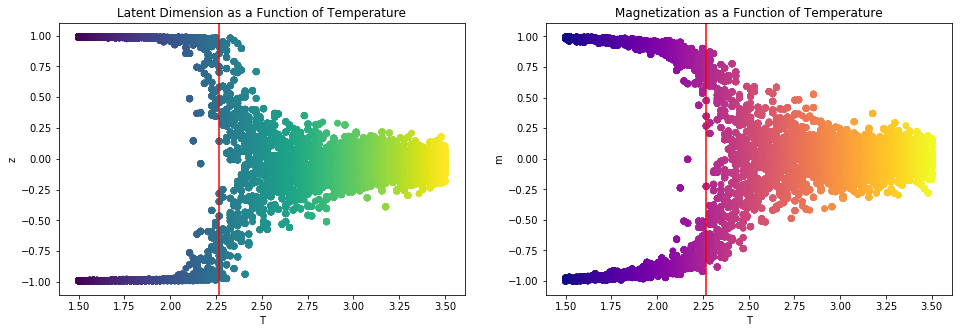

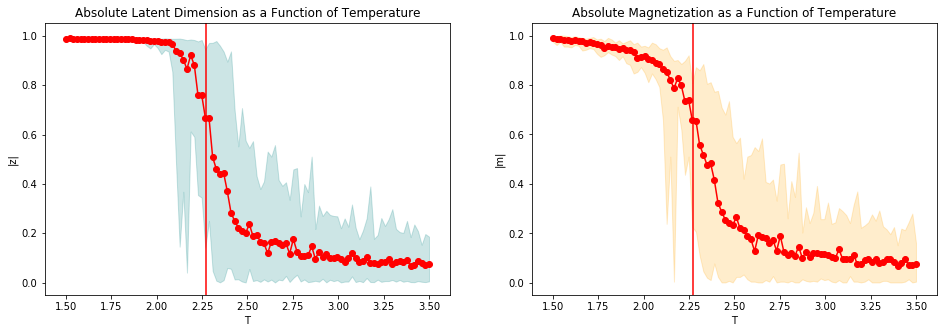

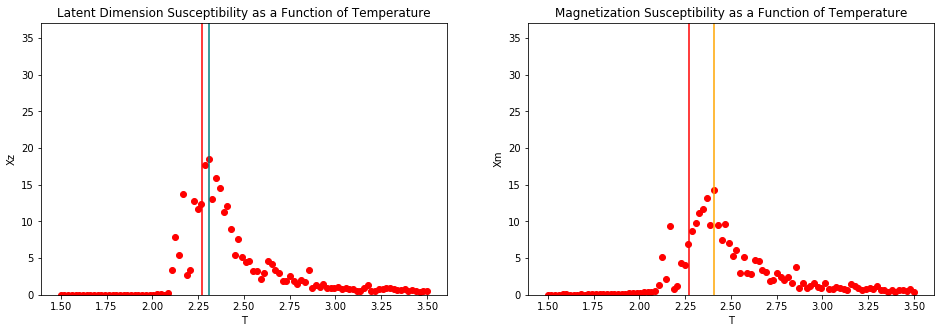

Max Susceptibility is at T = 2.308 Ground Truth:  2.269185
Absolute percent error:  1.711 %
Correlation coeff:  0.901


In [198]:
run_phase_analysis(ORIGINAL_MODEL_TAG, lattice_size=25, N=200)
run_critical_temp_analysis(ORIGINAL_MODEL_TAG, lattice_size=25, N=200)

### 2.4 Probing the Renormalization Hypothesis

Building off of Mehta & Schwab (2014), we use a notion of neuron activation and reconstruction to probe the presence of block-spin renormalization. Under our hypothesis, block-spin renormalization would manifest in neurons at higher levels being activated by local, non-overlapping regions in the input space. Stanley (1999) shows that - in models with phase transitions - the fixed points of renormalization flows are either a) homogenous states b) random states or c) critical points. If the model is converging to a block-spin renormalization then optimal compression would involve mirroring self-similar patterns across scales (note that all three fixed points above are effectively 'self-similar' in nature although the formal use of this term has a more specific meaning).

More concretely, if the network has learned a renormalization-based compression we expect that the weights would be such that neurons at a higher level are activated by local regions of input space as is confirmed in Mehta & Schwab (2014). Note that the fully-connected natue of the network means that the relative position of local clusters may not be preserved as there can be convergence to many equivalent - and still accurate - renormalization schemes.

In order to probe correspondence of neurons to input space values, we use the same gradient descent technology used to train the network in the first place. The weights of the network are frozen and a random input is fed forward through the encoder. The loss value is the difference between the value of a neuron in a specified level and a target value which would indicate the neuron is 'active'. We then do back propagation to identify the gradient of the loss in terms of the values in input space and adjust these values to reduce the loss. Additionally, we add an L1 regularization term to the loss which encourages the gradient descent to use relatively few neurons to maximize activation. The multiplicity of weakly connected input values makes it too easy to activate the neuron without this regularization.  The result of this process is a heat map which shows the input-space values which are most strongly connected to activating a given neuron.

As is clear from the figure below, there is no clear locality in the activation areas of the neurons in the second-from-top layer of the authors' network. We see random noise in the plots of Activation-Input. This noise means the optimization did not converge to a local cluster of input values which activate the target neuron in the second-from-last layer. While we cannot be sure, it would appear that 'accepting' the L1 penalty from using many input values means that no input values have relatively strong weights linking to the neuron as these would be preferred. So, we assume a uniform/random weight-coupling. This is not reminscent of block-spin renormalizaton.


In [0]:
class ActivationVisualization():
    '''
    This class takes a model and lattice size and determines which
    inputs in the original input space result in the activation
    of specifc neurons in a given layer and position.
    
    This is done by performing gradient descent on the input values
    with a loss defined by the different between the target neuron's
    value and a given activation target.
    '''
    def __init__(self, model, lattice_size, verbose=True):
        self.lattice_size = lattice_size
        self.verbose = verbose
        
        # Prepare the model for input-space gradient descent.
        
        # Configuration the model for input-space optimization
        # by freezing all params and deactivating dropouts.
        self.model = model.cuda().eval()
        
        for layer in self.model.encoder:
          layer.eval()
          
        for param in self.model.parameters():
          param.requires_grad = False

    def visualize(self, layer_number, neuron, target=1,
                  lr=0.1, weight_decay=1e-6, opt_steps=20,
                  regularizer_weight=0.005):
        
        layer = self.model.encoder[layer_number]
        
        if self.verbose:
          print("Visualizing neuron", neuron, "in layer: ", layer)
        
        # Add a forward hook to the model to capture the target neuron
        # value on forward passes.
        self.neuron_tensor = None
        def hook_fn(module, input, output):
          self.neuron_tensor = output[0, neuron]
        self.hook = layer.register_forward_hook(hook_fn)
        
        # Generate random input data to serve as initial values
        raw_data = np.random.choice([-1, 1], (1, self.lattice_size**2))
        
        # Load this data into a PyTorch Tensor.
        data = torch.FloatTensor(raw_data).float().cuda()
        data.requires_grad = True
        data_var = Variable(data, requires_grad=True)
        
        # Create an optimizer to update the input data.
        optimizer = torch.optim.Adam([data_var], lr=lr, weight_decay=weight_decay)
        
        # Optimize input values opt_steps times using loss defined by neuron
        # value of the target neuron.
        for n in range(opt_steps):  
          
          # Forward pass with curent data
          self.model(data_var)
          
          # Loss is based on target value of neuron with L1 regularization
          # of input values to force use of the most connected input data
          # rather than the multiplicity of weakly connected values.
          loss = (target-self.neuron_tensor)**2 + \
            ((regularizer_weight/625)*torch.sum(torch.abs(data_var)))
          
          # Perform back prop and gradient descent.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
        
        # Display
        if self.verbose:
          print("loss", loss.item())
          print("Neuron val", self.neuron_tensor.item())
          print()

        optimized_input = data_var.cpu().data.numpy()[0]
        self.calculated_input = optimized_input # save the optimized input
        
        input_data = self.calculated_input.reshape(
            (self.lattice_size, self.lattice_size))
        plt.imshow(input_data, cmap="plasma")
        
    def run_visualization(self, *args, **kwargs):
      try:
        self.visualize(*args, **kwargs)
      except Exception as e:
        self.hook.remove()
        raise e

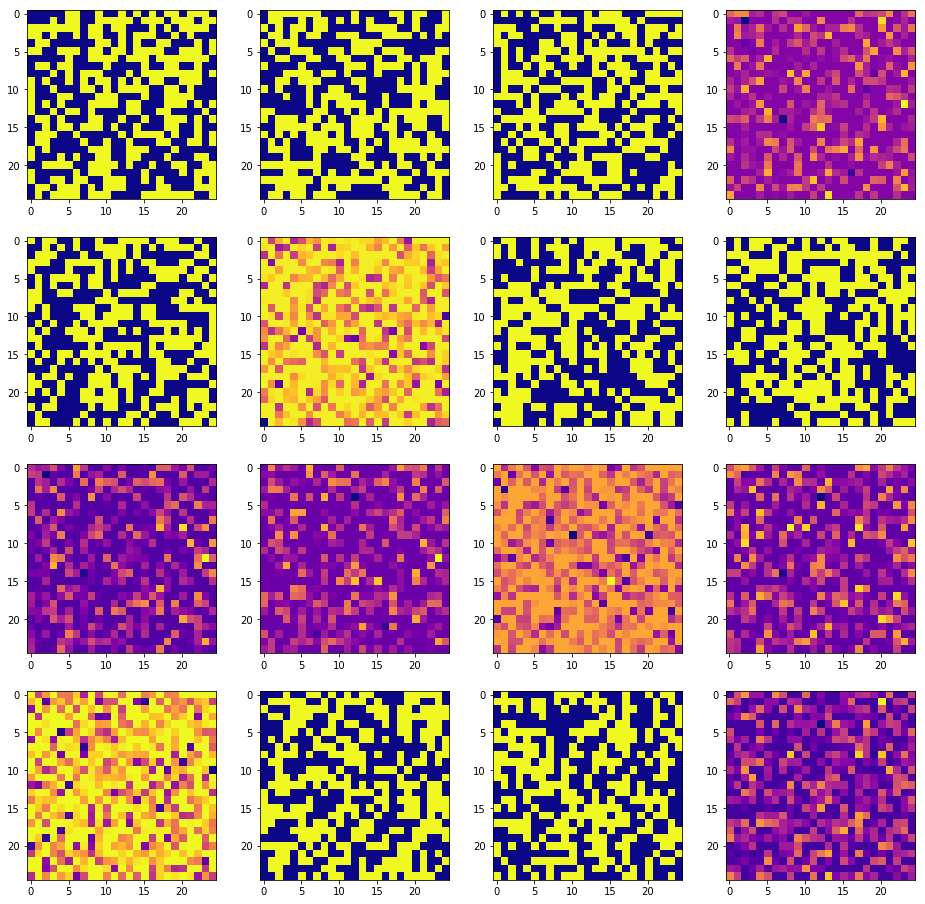

In [191]:
viz = ActivationVisualization(model=original_model, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))

for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=6, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)

plt.show()

### 2.5 Reconstruction

A second possible method to verify renormalization is reconstruction. If renormalization is occuring, the information critical to capture the structure of the data (at all scales) should be preserved through the compression. It is trivial that for a single latent value, meaningful structural patterns will be lost.

The figures below shows reconstructions which are made by passing data through the encoder and decoder. The first figure shows training data and the second shows reconstructions of new, randomly generated test data. We see that there is no preservation of structure. The latent variable encodes a 'mean' of the input which corresponds to magnetization. With a single neuron, this mean is effectively the best that can be done.

Later, we discuss why this single-neuron structure results in the identification of a first-order rather than the correct second-order phase transition. This is fundamentally connected to only being able to represent the mean and not the structue (and resultant dynamics) of the spin data.

In [0]:
def plot_reconstructions(model, sample_indices):
  model.eval()

  all_data = torch.from_numpy(dataset.data)
  all_data = Variable(all_data)
  all_data = all_data.float()

  if cuda:
    all_data = all_data.cuda()

  reconstructed_data, _ = model(all_data)
  sample_count = len(sample_indices)
  
  plt.figure(figsize=(16, 10))
  
  plt.tight_layout()
  for i,index in enumerate(sample_indices):
    temp = round(dataset.temperatures[index], 3)
    
    plt.subplot(2,sample_count,i+1)
    original_data = all_data[index, :].cpu().numpy().reshape(
        (lattice_size, lattice_size))
    org_magnetization = np.round(np.mean(original_data), 3)

    plt.title(f"Original. T: {temp}, <M> {str(org_magnetization)}")
    plt.imshow(original_data, vmin=-1, vmax=1)

    plt.subplot(2,sample_count,i+sample_count+1)
    recon_data = reconstructed_data[index, :].cpu().numpy().reshape(
        (lattice_size, lattice_size))
    recon_magnetization = np.round(np.mean(recon_data), 3)

    plt.title(f"Reconstructed. T: {temp}, <M> {str(recon_magnetization)}")
    plt.imshow(recon_data, vmin=-1, vmax=1)
    
  plt.show()
  
def plot_test_reconstructions(model, tests=4):
  test_data = []
  plt.figure(figsize=(16, 10))
  plt.tight_layout()
  for i in range(tests):
    _, data, _ = run_ising(0, lattice_size=25, temperature=2.25, MCMC_run_steps=200)
    test_data = np.array([data])
    model.eval()

    test_data = torch.from_numpy(test_data)
    test_data = Variable(test_data)
    test_data = test_data.float()

    if cuda:
      test_data = test_data.cuda()

    reconstructed_test_data, _ = model(test_data)

    plt.subplot(2,tests,i+1)  
    plt.imshow(test_data.cpu().numpy().reshape((25, 25)), vmin=-1, vmax=1)

    # Reconstructed
    plt.subplot(2,tests,i+tests+1)  
    plt.imshow(reconstructed_test_data.detach().cpu().numpy().reshape((25, 25)))
  plt.show()

**Reconstructions on Training Data**

Observe that, on this training data, the network accuratelt reconstructs the mean of the state (the magentization) but not the local structure. This is visible from the plots and from the calculated Magnetization values above each image. Each column corresponds to one state before and after a forward pass through the autoencoder.

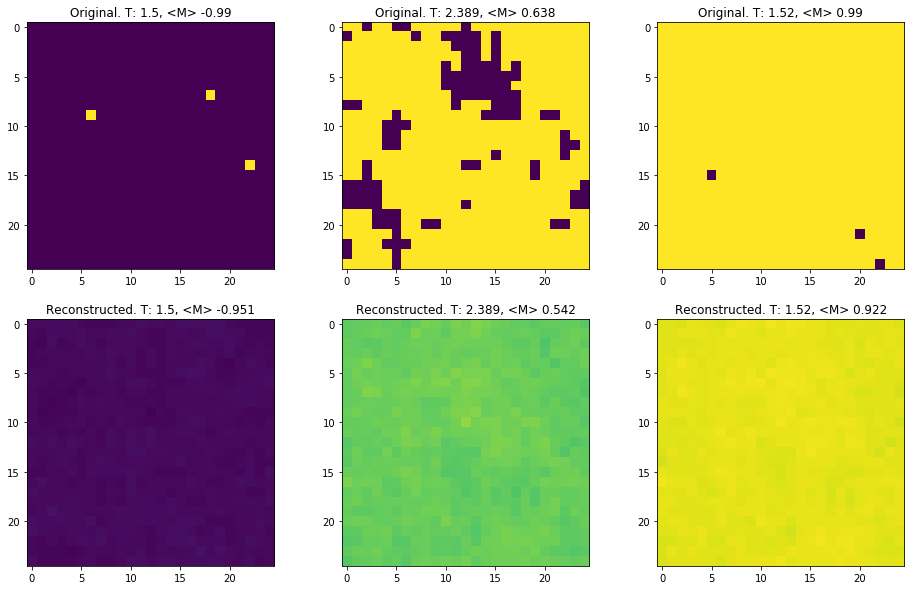

In [341]:
crit_index = np.argmin(np.abs(dataset.temperatures - CRITICAL_TEMP)) + 1000
plot_reconstructions(original_model, [0, crit_index+200, 200])

**Reconstructions on Test Data**

Note that all of the samples below are near the critical temperature, corresponding to the middle column in the figure above. It is interesting to observe that there is a little more noise in the reconstruction of these states. The reason for this is not immediately clear but it is clear there is no correspondence of the noise to the structure in the original data. I suspect there may be some overfitting in the training of the network. This is discussed more later.

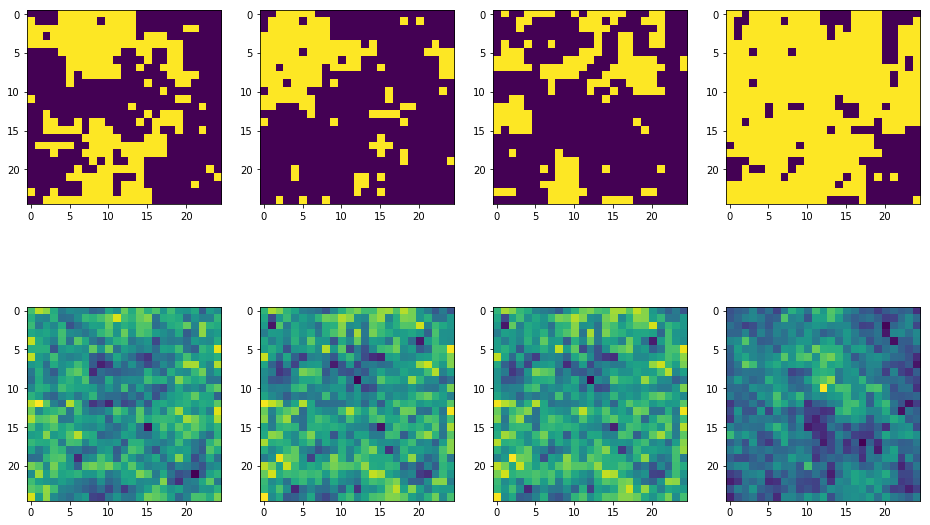

In [256]:
plot_test_reconstructions(original_model)

## 3. Exploration of Renormalization in Deep Neural Networks

The work above represents a replication of the original paper and introduces new methods to probe for renormalization. This is a theoretical foundation for the exploration which follows. The content below this was written separately by each author.



### 3.1 Overcoming the Information Bottleneck

The results above are encouraging in that they closely mirror those seen in the original paper. However, we do not see evidence that the network is converging to block-spin renormalization. 

We made a number of changes to the network structure in order to explore whether structural changes were preventing the implementation of renormalization. The most important amongst these was widening the latent dimension - starting with a dimensionality of 16. This was based on the hypothesis that compression to a single dimension meant that there was too little bandwidth to make capturing structural information worthwhile. Under renormalization, high level parameters should come to contain the key 'information' from groups of lower level parameters while maintaining the correct (but rescaled) interactions at the new, higher level. In order to allow the network to infer the value of this process, we decided more higher-level spins would be required.

We made three further changes:

  - Firstly, we removed drop out under the hypothesis that random removal of neurons was preventing the consistent learning of local structure/patterns and forcing other inference strategies.
  - Second, we added more layers and made the size difference between layers a consistent factor of two decrease. Again, the thinking being that this would provide a baseline set of parameters more ameanable to the learning of block-spin renormalization. 
  - Finally, we use tanh as the activation function across all layers. This means all neurons have activation values of between -1 and 1 and encourages learning weights which roughly map spin values to spin values rather than to arbitrary real positive values as under Rectified Linear activation in the original model.

**Results**


The results of these changes were interesting. Section 3.1.1 shows that the phase transition identification under this model was extremely poor. We could not get the results to converge to those seen in the paper regardless despite tuning of all learning parameters except dropout. However, section 3.1.2 and 3.1.3 show that there is evidence of local activation clusters and reconstruction of some local features. There is more analysis on each of these results below.

In [0]:
class WideAutoencoder16(nn.Module):
    def __init__(self, lattice_size, model_tag, p_dropout=0.5):
        super().__init__()
        
        self.model_tag = model_tag
        
        self.encoder = nn.Sequential(
            nn.Linear(lattice_size**2, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 16),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, lattice_size**2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded_values = self.encoder(x)
        x = self.decoder(encoded_values)
        return x, encoded_values

In [193]:
dropout = 0

num_epochs = 750
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 0
schedule = [500]
checkpoints = []

WIDE_16_TAG_NO_REG = "Z_16_no_reg"
wide_16_model_no_reg = WideAutoencoder16(
    lattice_size, WIDE_16_TAG_NO_REG, dropout).cuda()
if cuda:
    model = model.cuda()

wide_16_model_no_reg, loss = train_model(model=wide_16_model_no_reg,
                                  dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [75/750], loss:0.6337
epoch [150/750], loss:0.6295
epoch [225/750], loss:0.5986
epoch [300/750], loss:0.6038
epoch [375/750], loss:0.5887
epoch [450/750], loss:0.5836
epoch [525/750], loss:0.5773
epoch [600/750], loss:0.5767
epoch [675/750], loss:0.5762
epoch [750/750], loss:0.5759
Final loss: loss:0.5759


In [0]:
encoded = encode_data(wide_16_model_no_reg, dataset)

#### 3.1.1 Phase Detection Results

**Note**:  Under the assumption that the latent variables would represent renormalized 'spins', we took the average of these latent variables to create a single latent 'magnetization' which we then processed as with the single latent value above. We are fairly confident this process is valid given the results in later sections but here we obseved very poor results.

The first figure below displays that the model no longer cleanly represents the symmetry breaking under the critical value with negative and positive magnetization being mapped to similar average latent magentization. There is some kind of 'phase change' in the latent dimension near the citical value - with a jump in the variance - but the variance remains large throughout the result of the temperature range. This stands in contrast to the result above where there was large variance only in a very narrow band around the critical temperature.

The error on the critical temperature identification is low but this is not reliable given the relative uniformity of the susceptibility measure (note the scale is locked to keep results comparable across the latent/empirical magnetization but the values are uniform even at closer scale). The small error reveals the importance of the Pearon's r coefficient which is much lower here than above at roughly 0.5 vs 0.9. This indicates a much worse fit to the real susceptibility.

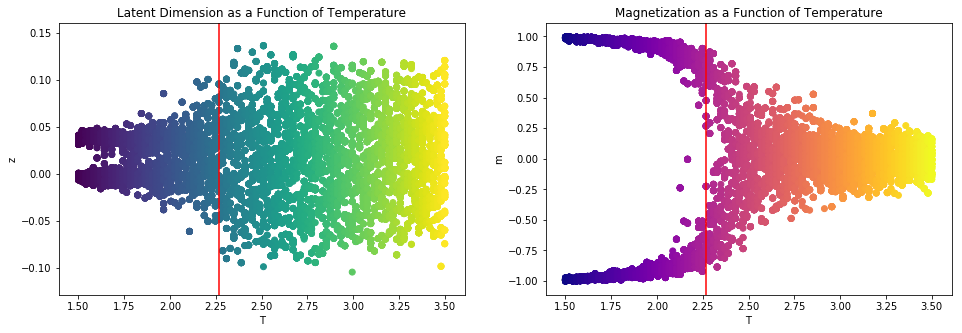

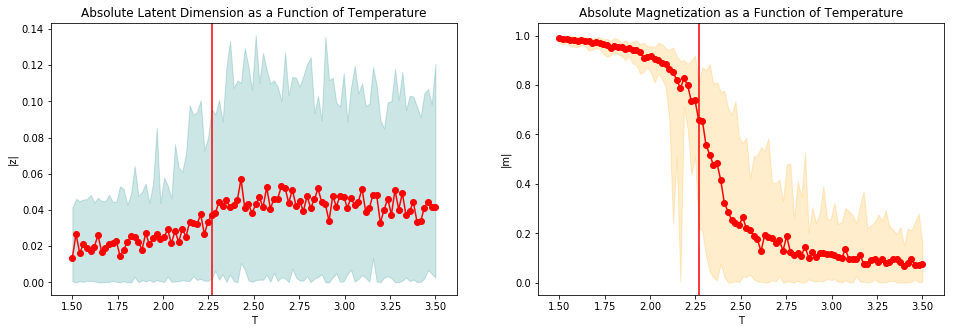

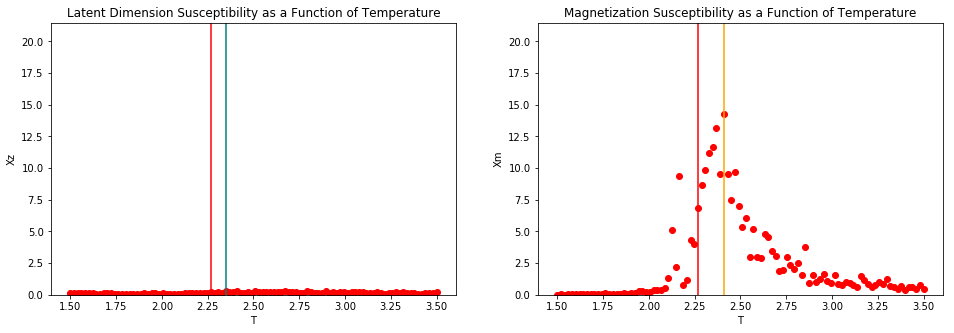

Max Susceptibility is at T = 2.348 Ground Truth:  2.269185
Absolute percent error:  3.473 %
Correlation coeff:  0.542


In [201]:
run_phase_analysis(WIDE_16_TAG_NO_REG, lattice_size=25, N=200)
run_critical_temp_analysis(WIDE_16_TAG_NO_REG, lattice_size=25, N=200)

#### 3.1.2 Input-Activation Clustering

Below, we run two clustering analyses. The first figure shows the input values which activate all 16 neurons in the top layer of the encoder. The second figure shows the activations for the first four neurons in each of the four layers - showing how the clusters evolve across scales.

#### Clustering at the Top Level

The figure directly below reveals that there is indeed some level of local clustering in the input activations for the top level neurons. It appears that each neuron is excited by one region of inputs (this region may cross the periodic bounds in the underlying data) and is inhibited by one region. The inhibition is in purple (indicating low values lead to activation) and the excitement in yellow. The clustering doesn't align with exactly what we would see under block renormalization. 

Under renormalization, we would expect each top level neuron to correspond to a distinct and non-overlapping region of the input space below, likely without the sepaate excitory and inhibitory sections. This means the clusters below are by no means conclusive evidence of renormalization.

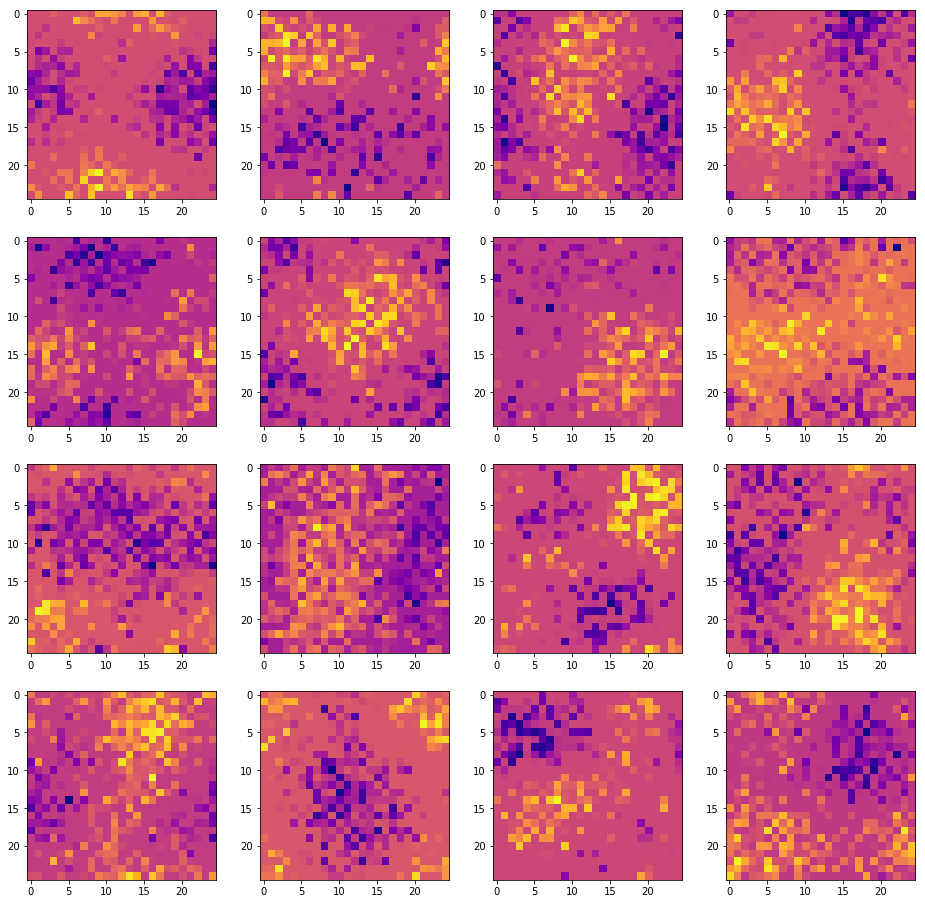

In [304]:
viz = ActivationVisualization(model=wide_16_model_no_reg, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))

no_reg_cluster_data = []

for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=12, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)
  
  no_reg_cluster_data.append(viz.calculated_input)

plt.show()

#### Clustering Across Layers

The plots below show  the input activations for the first four neurons in each layer. This gives a sense of how activations scale across layers. Here again, there is reason to doubt renormalization. We would expect to see cohesive activation clusters across layers with the clusters growing as the layer gets higher (and subsumes all the input parameters represented by the neurons below). We do not see this dynamic here.

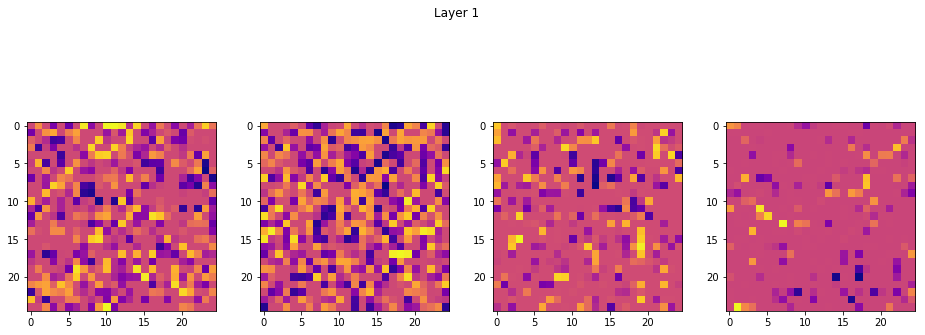

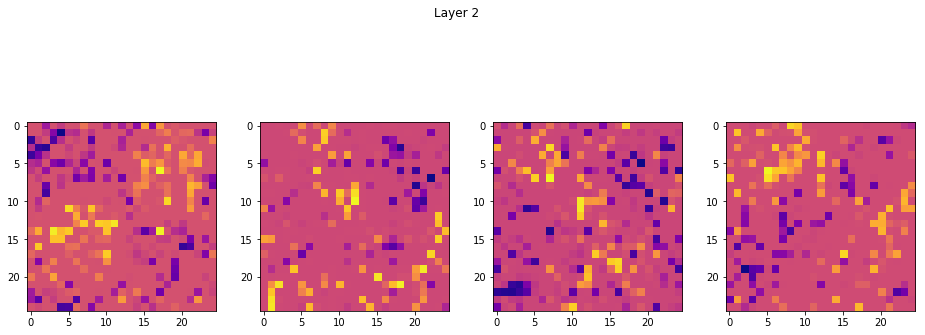

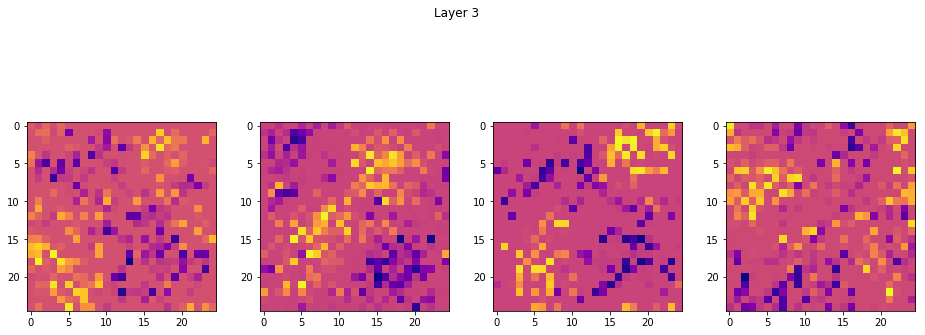

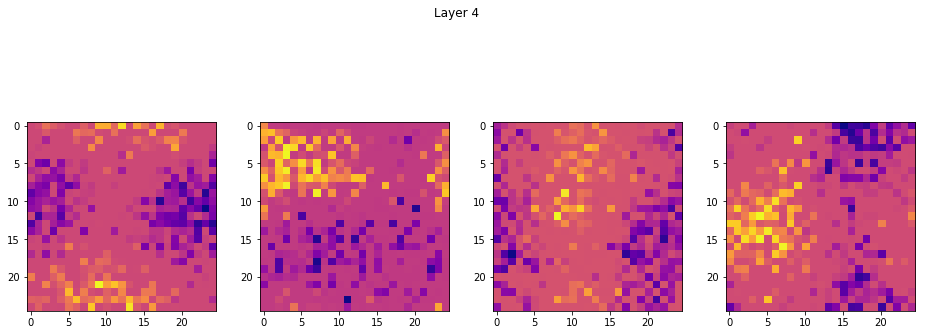

In [289]:
viz = ActivationVisualization(model=wide_16_model_no_reg, lattice_size=25, verbose=False)

layers = [0, 3, 6, 12]

for layer_num, layer in enumerate(layers):
  plt.figure(figsize=(16, 16))
  plt.tight_layout()
  plt.suptitle(f"Layer {layer_num+1}")
  for i in range(4):
    plt.subplot(4, 4, i+1)
    viz.run_visualization(layer_number=layer, neuron=i, opt_steps=1000, target=1,
                        lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)

  plt.show()

#### 3.1.3 Reconstruction Analysis

The plots below show that, unlike with the original model, there is some success in reconstruction for both training and test data. It is hard to quantify this success but the there is clear correspondence between areas of low and high values in the input and output. 

It is worth noting that the reconstruction does not preserve local structure, as was the case in Metha and Schwab. It appears that the network is 'smoothing' over the input values in the reconstruction. This is discussed in more detail below.

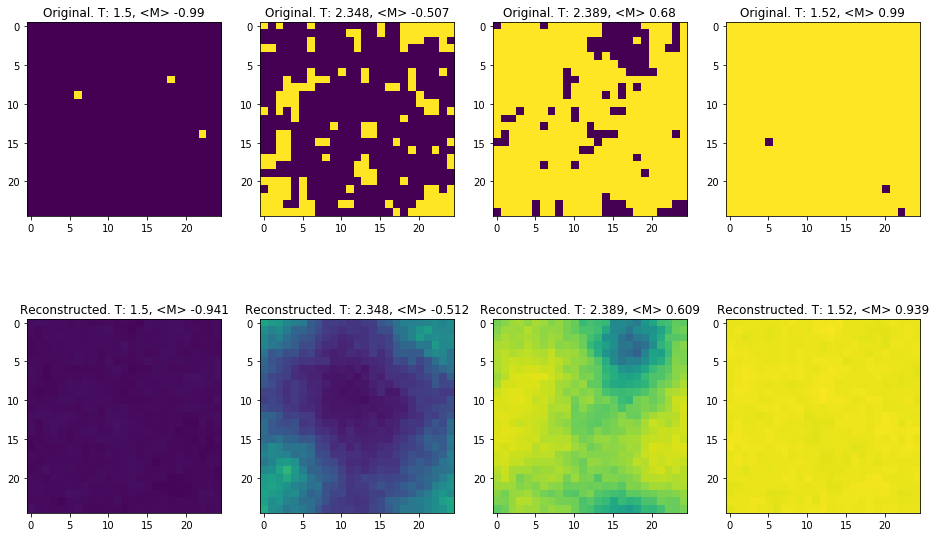

In [219]:
crit_index = np.argmin(np.abs(dataset.temperatures - CRITICAL_TEMP)) + 1000
plot_reconstructions(wide_16_model_no_reg, [0, crit_index - 20, crit_index + 220, 200])

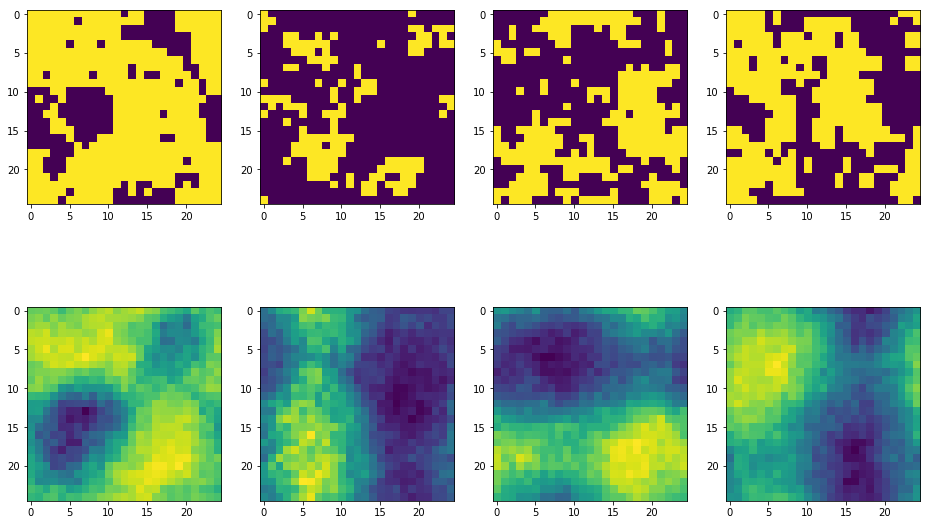

In [255]:
plot_test_reconstructions(wide_16_model_no_reg)

### 3.2 Testing Implication of Clustering on Control Data

In order to understand the origin of the input activation clustering, we train the same model on two different datasets. First, we train on noise to test that the local clustering isn't an inherent part of the new model (with the wider latent dimension). Second, we train on synthesized data which has a combination of some order and noise but no self-similarity. We generate this data by adding noise to a two-dimensional sin wave where the frequency and amplitude of the wave is different in every example. An sample of a single example is given immidiately below this text.

If block-spin renormalization is happening, we would hope to see clustering in neither of the two datasets - indicating that clustering occurs in the ising model due to the unique information advantage presented by the self-similar data.

The results do not present this confirmatory evidence. From the first figure below, it is clear that there is no clustering in the model trained on random noise data. This means the clustering is not inherent to the model. However, the second figure shows that clustering is occurring in the model trained on semi-ordered data. 

The nature of the clusters provides some insight into the role the activation clusters are playing in the autoencoder. It appears that top level neurons are learning large-scale features common n the data and then using these features to 'rebuild' the input by mixing the large scale features. This is not conclusive proof that the local-activation clustering in the model trained on Ising Data  is not due to renormalization but it would seem to suggest that the model is learning large scale features instead of finding a renormalization which retains order-parameter information across scales. This kind of lage-scale feature learning would produce the smoothing which seems to be evident with the reconstruction ignoring the small scale. This would also explain the large increase in variance post-critical point, given the latent neurons would be encoding a mixture of different macro features.

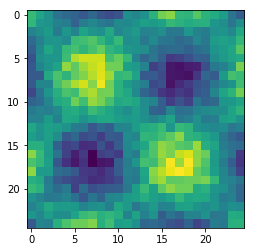

In [283]:
# Below is an example of a single data point used to the train this
# second model.
plt.imshow(ordered_random_data[0].reshape((25, 25)))

In [262]:
random_data = np.random.choice([-1, 1], (20000, 625))
random_dataset = IsingDatasetNumpy(data=random_data, file_name="random_data_lattice_25_N_200")

# Learning params
num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
p_dropout = 0
schedule = []
checkpoints = []
L1_reg = 0
    
  
# Build model
RANDOM_MODEL_TAG = "RANDOM_WIDE_16"
random_model = WideAutoencoder16(
    lattice_size, RANDOM_MODEL_TAG, p_dropout=p_dropout).cuda()

if cuda:
    random_model = random_model.cuda()


# Train
random_model, loss = train_model(model=random_model,
                                  dataset = random_dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [20/200], loss:0.9982
epoch [40/200], loss:0.9963
epoch [60/200], loss:0.9959
epoch [80/200], loss:0.9958
epoch [100/200], loss:0.9957
epoch [120/200], loss:0.9957
epoch [140/200], loss:0.9957
epoch [160/200], loss:0.9956
epoch [180/200], loss:0.9956
epoch [200/200], loss:0.9956
Final loss: loss:0.9956


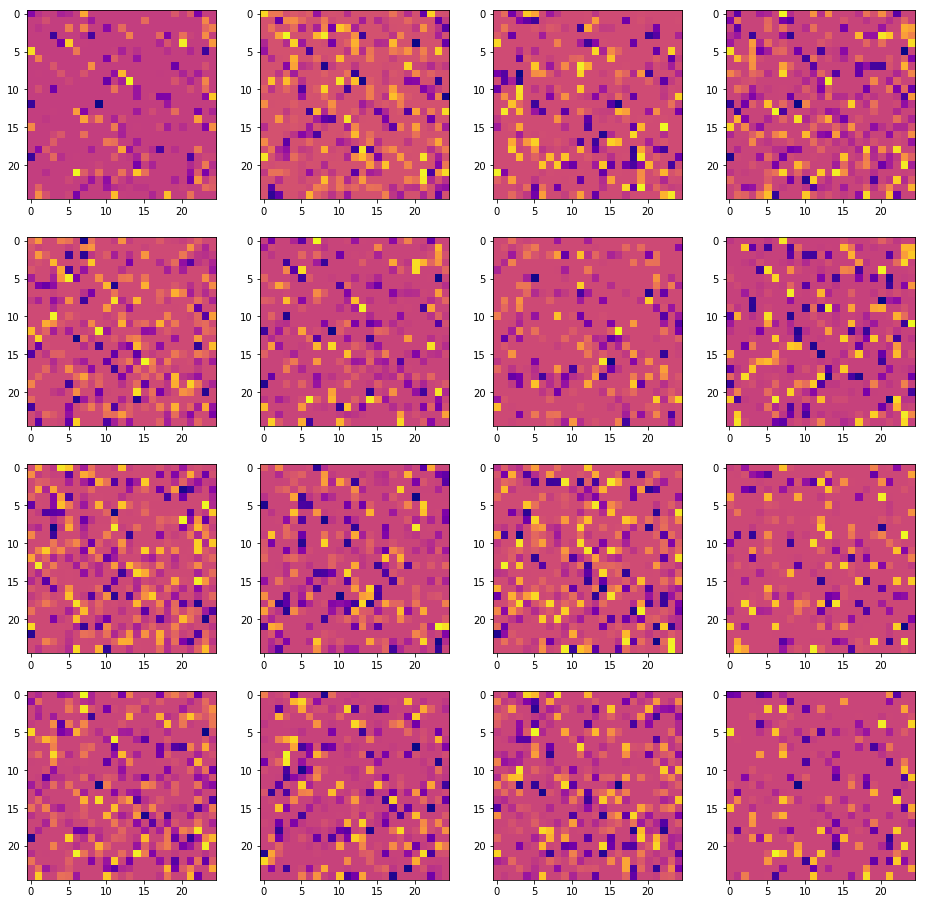

In [263]:
viz = ActivationVisualization(model=random_model, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))

for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=12, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)

plt.show()

In [281]:
ordered_random_data = []
for _ in range(20000):
  array = np.random.uniform(-1, 1, size=(25, 25))

  points = np.linspace(-1, 1, 25)
  xs, ys = np.meshgrid(points, points)


  amp = np.random.uniform(2, 5)
  freq = np.random.uniform(2, 5)
  
  array += amp*np.sin(freq*xs)*np.sin(freq*ys)
  ordered_random_data.append(array.flatten())

ordered_random_data = np.array(ordered_random_data)

ordered_random_dataset = IsingDatasetNumpy(data=ordered_random_data,
                                   file_name="random_data_lattice_25_N_200")

# Learning params
num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
p_dropout = 0
schedule = []
checkpoints = []
L1_reg = 0
    
  
# Build model
ORDERED_RANDOM_MODEL_TAG = "ORDERED_RANDOM_WIDE_16"
ordered_random_model = WideAutoencoder16(
    lattice_size, ORDERED_RANDOM_MODEL_TAG, p_dropout=p_dropout).cuda()

if cuda:
    ordered_random_model = ordered_random_model.cuda()


# Train
ordered_random_model, loss = train_model(model=ordered_random_model,
                                  dataset = ordered_random_dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [20/200], loss:2.3099
epoch [40/200], loss:1.9144
epoch [60/200], loss:1.7281
epoch [80/200], loss:1.7108
epoch [100/200], loss:1.7053
epoch [120/200], loss:1.7016
epoch [140/200], loss:1.6988
epoch [160/200], loss:1.6972
epoch [180/200], loss:1.6962
epoch [200/200], loss:1.6953
Final loss: loss:1.6953


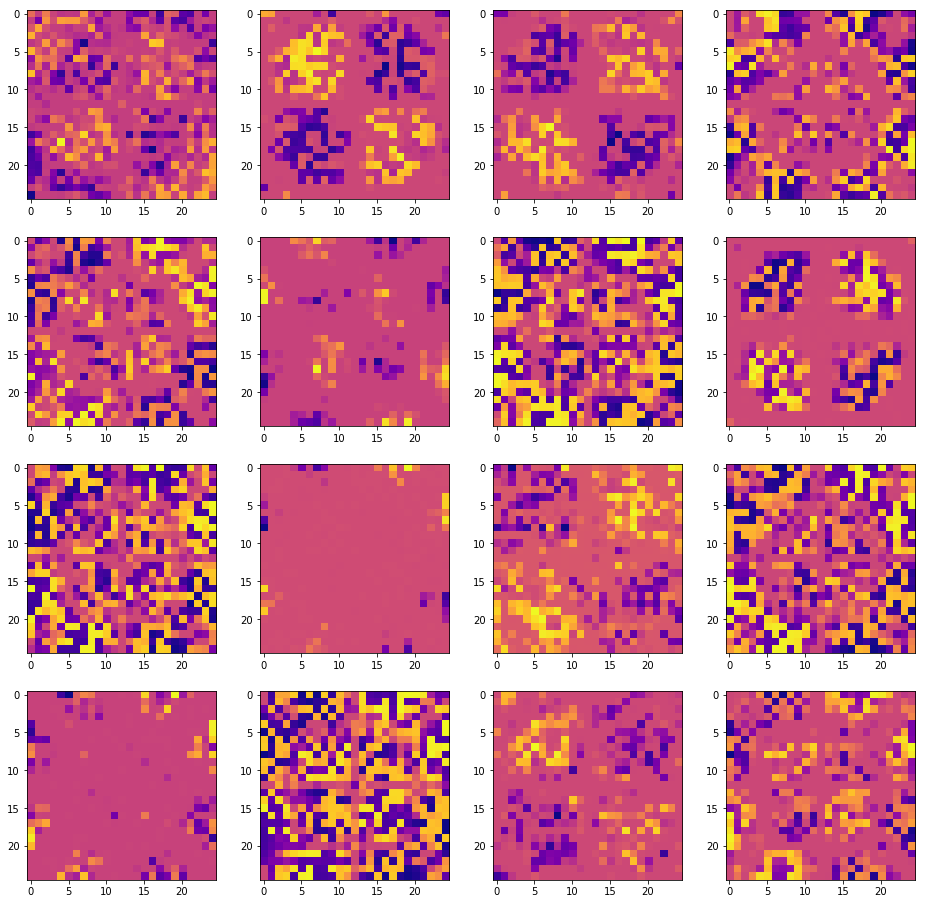

In [282]:
viz = ActivationVisualization(model=ordered_random_model, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))


for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=12, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)

plt.show()

### 3.3 Reimplementing Regularization.

A key difference between the autoencoder trial above and the original model is the absence of the regularization from dropout. Given the conclusion above, that the network is learning specific macro-features, we explore reintroducing regularization.


We first retrain the exact same model using 16 latent dimensions with a 50% dropout rate, equal to the dropout from the original model. This produces very good phase-identification results but the clustering dynamic and reconstruction accuracy is lost. Please see below for more detailed analysis.



In [202]:
dropout = 0.5

num_epochs = 750
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 0
schedule = [500]
checkpoints = []

WIDE_16_TAG = "Z_16"
wide_16_model_dropout = WideAutoencoder16(lattice_size, WIDE_16_TAG, dropout).cuda()
if cuda:
    model = model.cuda()

wide_16_model_dropout, loss = train_model(model=wide_16_model_dropout, dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [75/750], loss:0.6728
epoch [150/750], loss:0.6557
epoch [225/750], loss:0.6496
epoch [300/750], loss:0.6482
epoch [375/750], loss:0.6468
epoch [450/750], loss:0.6458
epoch [525/750], loss:0.6454
epoch [600/750], loss:0.6451
epoch [675/750], loss:0.6448
epoch [750/750], loss:0.6451
Final loss: loss:0.6451


In [0]:
encoded = encode_data(wide_16_model_dropout, dataset)

#### 3.3.1 Phase Tranisition Analysis

The plots below show the phase transition identification metrics for the regularized latent-16 model. Once again, there is very close correspondence between the empirical magnetization and the latent variable values. In fact, the fit between the susceptibility values is even higher here at approximately 0.95. 

Two things are worth noting. First, the result is encouraging because unlike in the first model there are 16 latent values rather than one. A cursory check reveals that these values are not the same. So the average is coming to represent the order parameter not just a single value. This is oughly in line with how renormalization should work. Second, the diagrams below are plotted after a rescaling operation. The model produces average magnetization much lower than 1/-1 and we rescale such that the maximum absoute magnetization is equal to 1. This is reminiscent of the rescaling of the coupling parameters which would be required under analytical rescaling. This is by no means confirmation that renormalization is occuring.

However, despite these promising initial results, clustering and reconstruction analysis reveals that we appear to be in a similar regime as the original model.

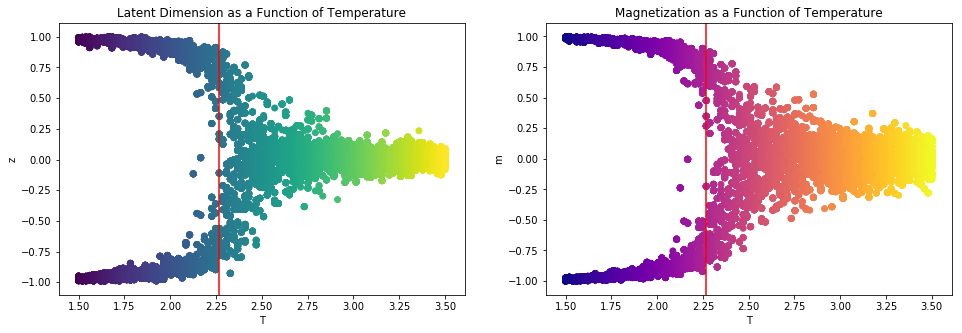

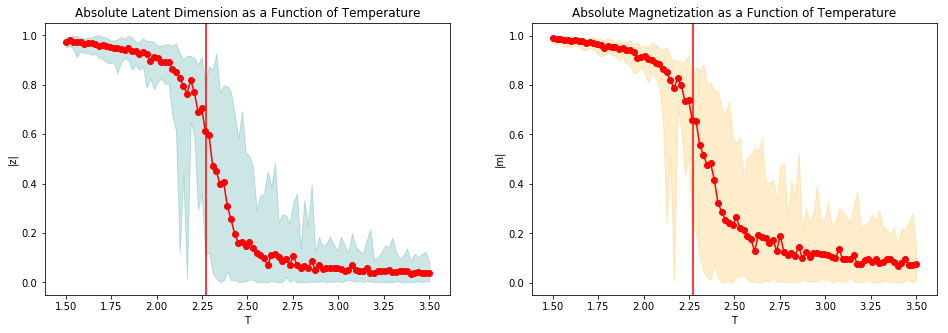

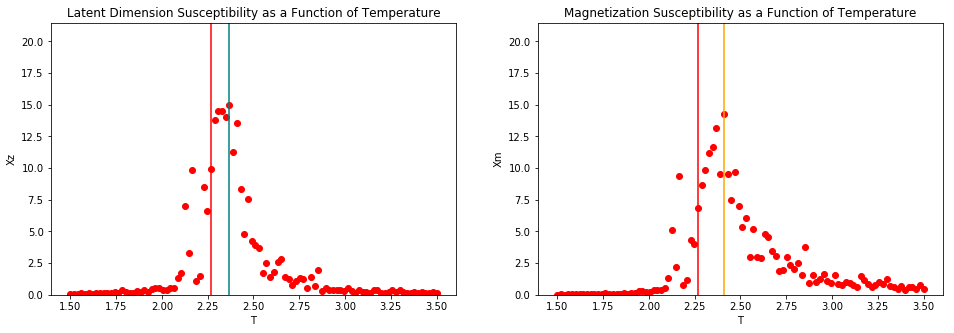

Max Susceptibility is at T = 2.369 Ground Truth:  2.269185
Absolute percent error:  4.399 %
Correlation coeff:  0.937


In [206]:
run_phase_analysis(WIDE_16_TAG, lattice_size=25, N=200, scale=True)
run_critical_temp_analysis(WIDE_16_TAG, lattice_size=25, N=200, scale=True)

#### 3.3.2 Input-Activation Clustering Analysis

The plots below show that, once again, there is no coherent clustering in the inputs which activate the top layer neurons. This means the phase transition identification appeas to be made through a different inference scheme that block-spin renormalization.

Based on the reconstruction analysis, we suspect that the model may simply be learning an average magnetization distributed across the latent neurons. The reconstructed images are mean-accurate but do not capture any local structure. 

Note that this is quite different from mean-field analysis. When applied to the Ising model, mean-field analysis tends to miss the phase transition entirely because it smooths over the dynamics which result in the phase transition. Here, we still detect the phase transition but appear to do so by infering the mean of the magnetization order-parameter without any notion of local structure/correlation.

It is possible that this renormalization is occuring in some way but, as mentioned above, the drop out is hampering the consistent formation of cluster weights/randomizing these weights in some way. We probe this below.

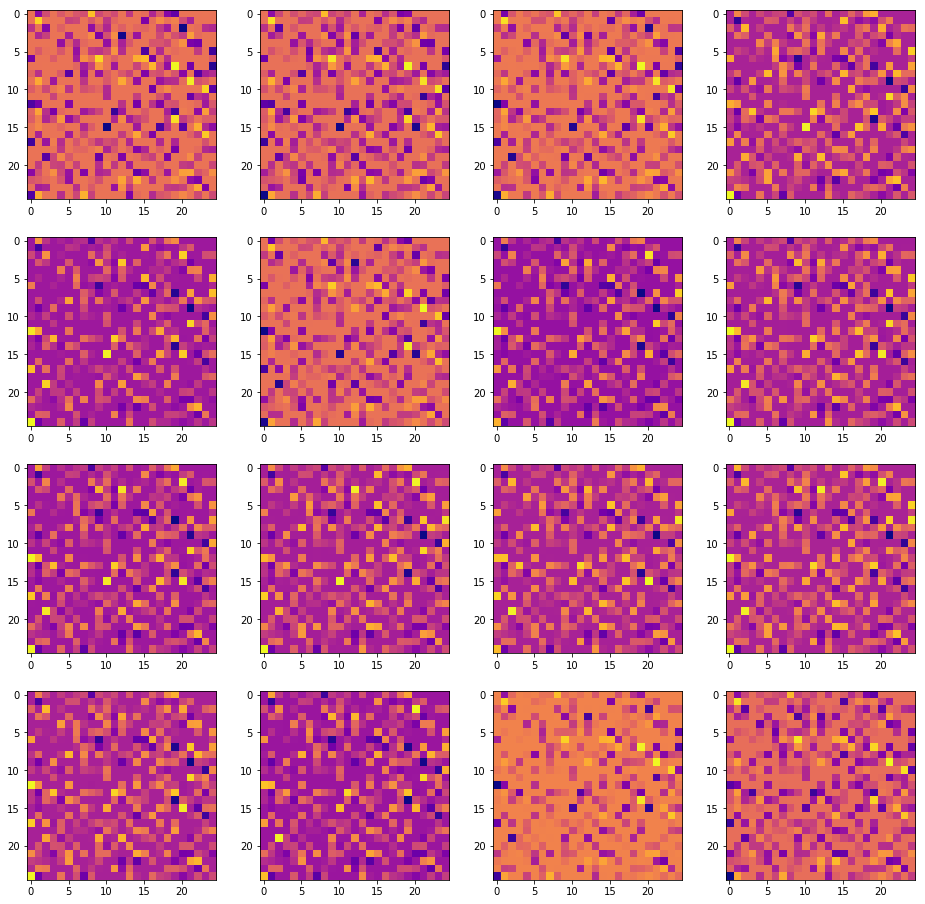

In [207]:
viz = ActivationVisualization(model=wide_16_model_dropout, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))

for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=12, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)
  
plt.show()

#### 3.3.3 Reconstruction Analysis

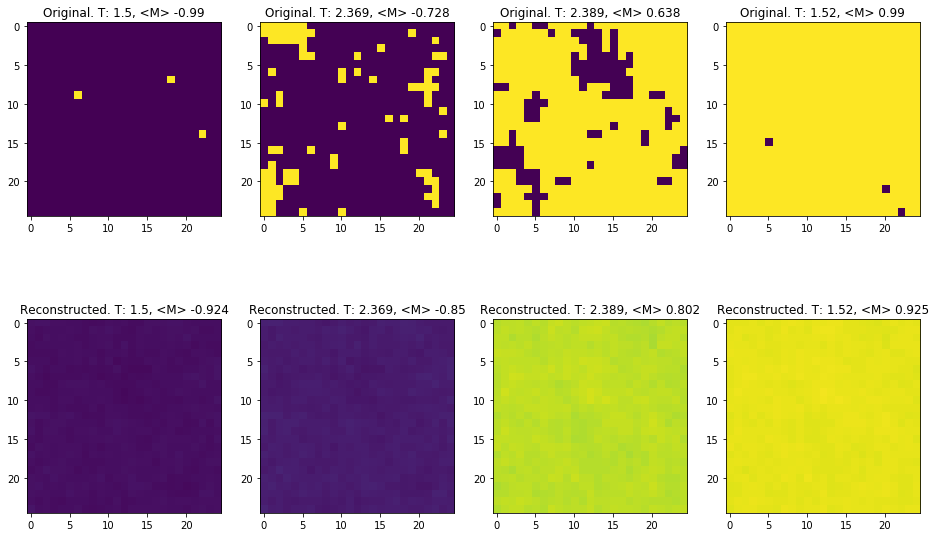

In [216]:
crit_index = np.argmin(np.abs(dataset.temperatures - CRITICAL_TEMP)) + 1000
plot_reconstructions(wide_16_model_dropout, [0, crit_index, crit_index + 200, 200])

### 3.4 Using L1 Regularization

As above, we suspect dropout regularization - while important for learning the phase transition - may be hampering the development of a renormalization inference pattern. We also suspect that even with drop out, the model is using latent dimensions to encode the mean magentization rather than using the space to encode information on structure/self-similarity.

In order to explore whether these suspicions hold, we try L1 regularization on the latent variable outputs. Our thinking is that this will prevent the learning of macro-features which occurred without regularization while also forcing any value in the latent space to have significant value (to overcome the L1 loss). In theory, this shuld prevent the simple distributed encoding of the mean.

The results are, unforunately, similar to those seen above under dropout although slightly worse in terms of the correlation of susceptibility with an r value of 0.8. Once again, we see no evidence of local activation clustering. This dismisses the theory that dropout was preventing the emergence of this dynamic.

In [208]:
dropout = 0

num_epochs = 750
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 5e-6
schedule = [500]
checkpoints = []

WIDE_16_TAG_L1 = "Z_16_L1"
wide_16_model_L1 = WideAutoencoder16(lattice_size, WIDE_16_TAG_L1, dropout).cuda()
if cuda:
    model = model.cuda()

wide_16_model_L1, loss = train_model(model=wide_16_model_L1, dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [75/750], loss:0.6511
epoch [150/750], loss:0.6463
epoch [225/750], loss:0.6418
epoch [300/750], loss:0.6406
epoch [375/750], loss:0.6440
epoch [450/750], loss:0.6399
epoch [525/750], loss:0.6382
epoch [600/750], loss:0.6380
epoch [675/750], loss:0.6380
epoch [750/750], loss:0.6379
Final loss: loss:0.6379


In [0]:
encoded = encode_data(wide_16_model_L1, dataset)

#### 3.4.1 Phase Transition Analysis

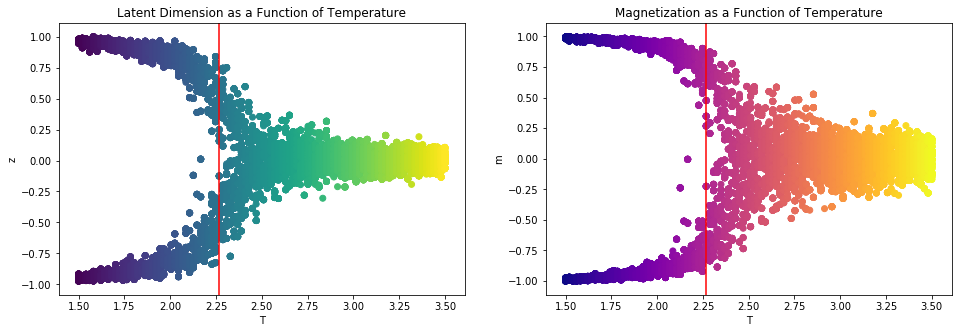

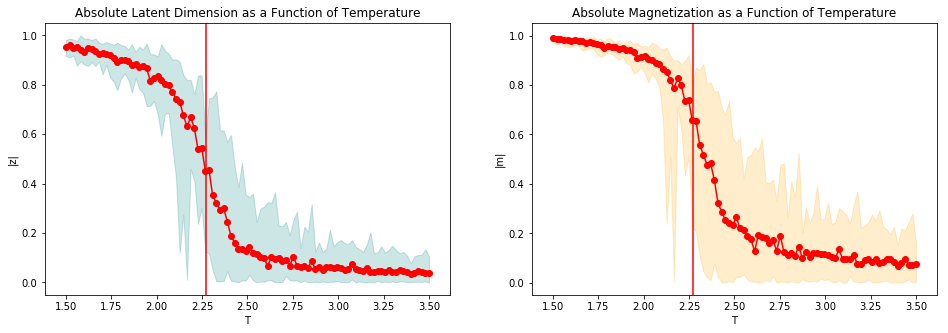

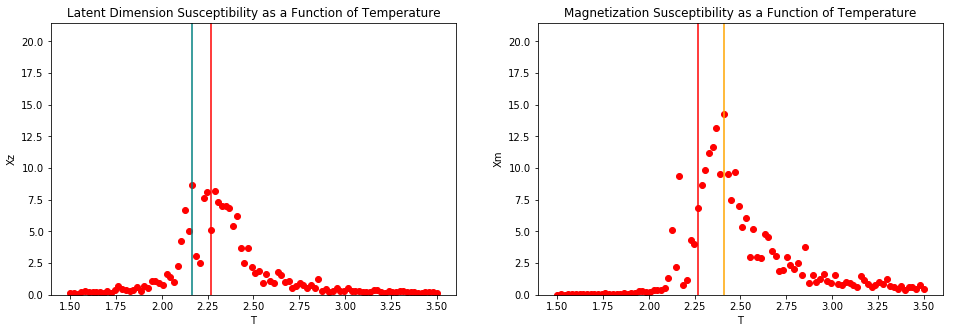

Max Susceptibility is at T = 2.167 Ground Truth:  2.269185
Absolute percent error:  4.503 %
Correlation coeff:  0.801


In [211]:
run_phase_analysis(WIDE_16_TAG_L1, lattice_size=25, N=200, scale=True)
run_critical_temp_analysis(WIDE_16_TAG_L1, lattice_size=25, N=200, scale=True)

#### 3.4.2 Input-Activation Clustering Analysis

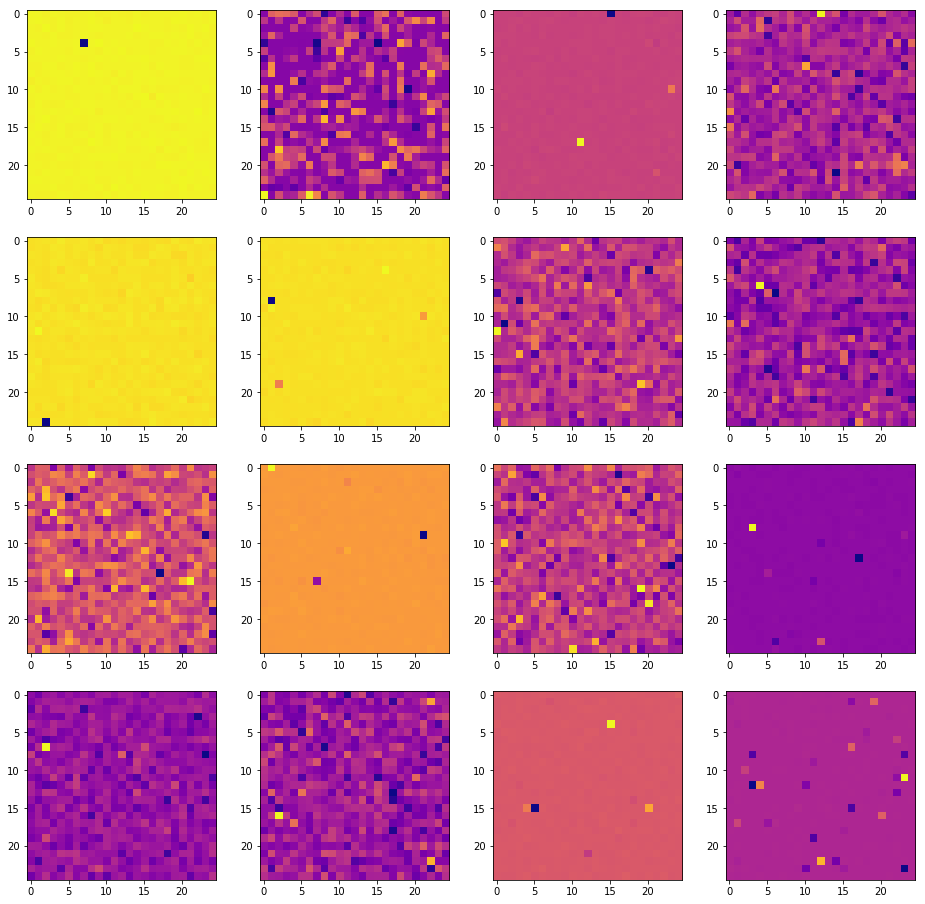

In [311]:
viz = ActivationVisualization(model=wide_16_model_L1, lattice_size=25, verbose=False)
plt.figure(figsize=(16, 16))

wide_16_l1_cluster_data = []
for i in range(16):
  plt.subplot(4, 4, i+1)
  viz.run_visualization(layer_number=12, neuron=i, opt_steps=1000, target=1,
                      lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)
  
  wide_16_l1_cluster_data.append(viz.calculated_input)
plt.show()

#### 3.4.3 Reconstruction Analysis

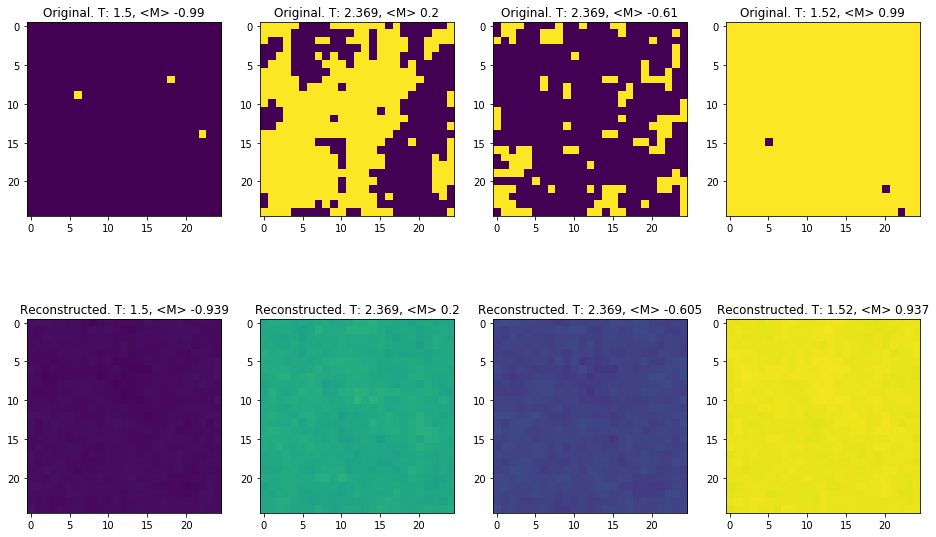

In [0]:
crit_index = np.argmin(np.abs(dataset.temperatures - CRITICAL_TEMP)) + 1000
plot_reconstructions(wide_16_model_L1, [0, crit_index + 20, crit_index + 180, 200])

## 4. Varying Latent Dimension

Section 3 above explored an single configuration of an autoencode with a wider latent dimensionality. We showed that without regularization, the model ended up learning macro-structure at the expense of phase-transition identification accuracy. With regularization, results were promising but all local structure in the input activations of higher-level neurons was lost.

In this section, we explore different latent dimensionality under the hypothesis that a somewhat narrower space may allow us to balance out the learning dynamic which requires regularization - the learning of macro-features - while still giving the information space to encourage renormalization-like clustering.

We explore autoencoders with the same layer structure as the one above, only varying the number of neurons at the top layer of the encoder.

### 4.1 Latent Dimensionality of 4

With a latent dimensionality of four and no regulation, we see our first occurrence of accurate phase-transition and clustering. This is initial evidence that the hypothesized trade-off outlined above holds. It is possible to have enough latent dimensionality to allow some notion of structure without having so much as too require regularization.

Unfortunately, the clustering pattern is still not reminiscent of block-spin renormalization. The presence of large vertical stripes which cover half the input space or two distinct, circular regions of activation for a single neuron point toward the learning of macro-features. Further, the phase identification is the least accurate thus far with a correlation value of 0.7. Again, the error is small but with the low correlation this metric does not appear reliable.

The balance of structural information and phase-transition identification does mean that further investigative work is worthwhile. As outlined in the appendix, it may be possible that different training regimes or network structures could produce phase-identification with renormalization-like activation patterns. As a first step, we explore increasing the latent dimension to eight below. We hope that allowing moe information in the latent dimension will allow the learning of local structure while retaining the phase transition information.

In [0]:
class WideAutoencoder4(nn.Module):
    def __init__(self, lattice_size, model_tag, p_dropout=0.5):
        super().__init__()
        
        self.model_tag = model_tag
        
        self.encoder = nn.Sequential(
            nn.Linear(lattice_size**2, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 4),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(4, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, lattice_size**2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded_values = self.encoder(x)
        x = self.decoder(encoded_values)
        return x, encoded_values

In [294]:
dropout = 0

num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 0
schedule = []
checkpoints = []

WIDE_4_TAG_DROPOUT = "Z_4_dropout"
wide_4_model_dropout = WideAutoencoder4(
    lattice_size, WIDE_4_TAG_DROPOUT, dropout).cuda()

if cuda:
    wide_4_model_dropout = wide_4_model_dropout.cuda()

wide_4_model_dropout, loss = train_model(model=wide_4_model_dropout,
                                  dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)
encoded = encode_data(wide_4_model_dropout, dataset)

epoch [20/200], loss:0.6667
epoch [40/200], loss:0.6378
epoch [60/200], loss:0.6344
epoch [80/200], loss:0.6270
epoch [100/200], loss:0.6234
epoch [120/200], loss:0.6192
epoch [140/200], loss:0.6131
epoch [160/200], loss:0.6107
epoch [180/200], loss:0.6092
epoch [200/200], loss:0.6060
Final loss: loss:0.6060


In [0]:
encoded = encode_data(wide_4_model_dropout, dataset)

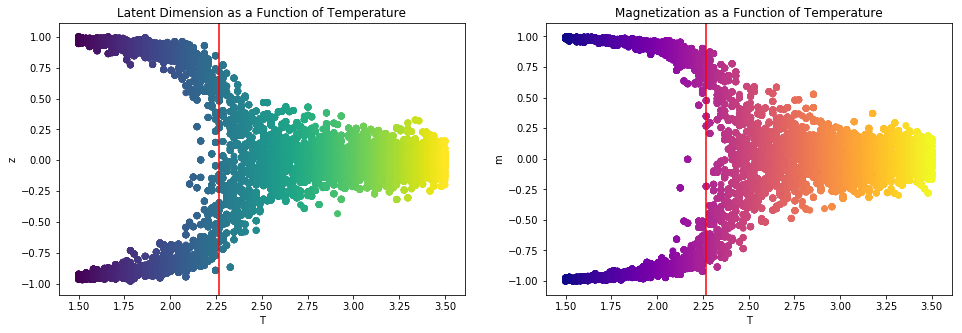

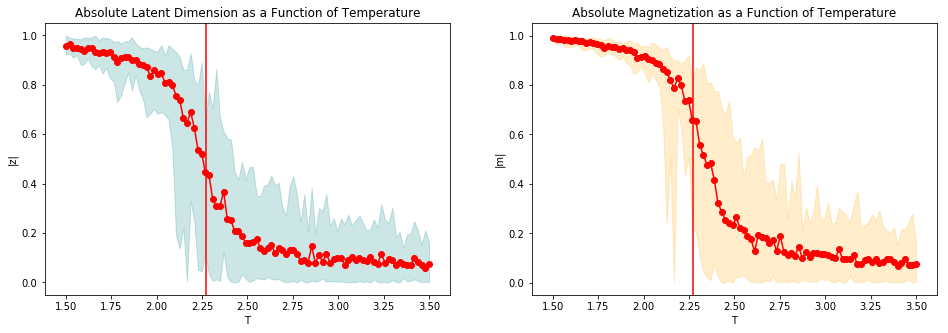

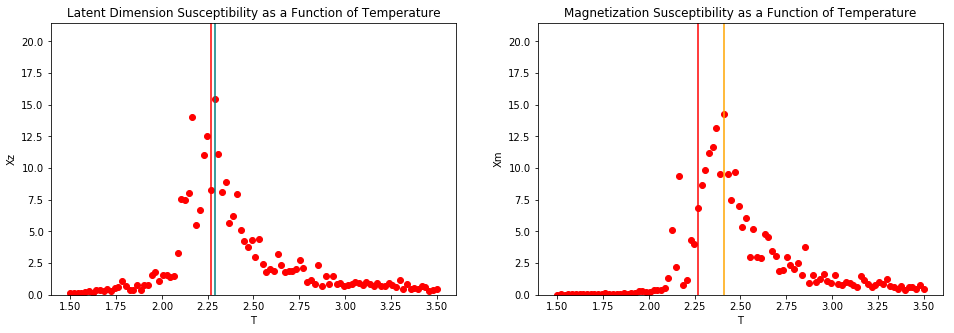

Max Susceptibility is at T = 2.288 Ground Truth:  2.269185
Absolute percent error:  0.829 %
Correlation coeff:  0.727


In [296]:
run_phase_analysis(WIDE_4_TAG_DROPOUT, lattice_size=25, N=200, scale=True)
run_critical_temp_analysis(WIDE_4_TAG_DROPOUT, lattice_size=25, N=200, scale=True)

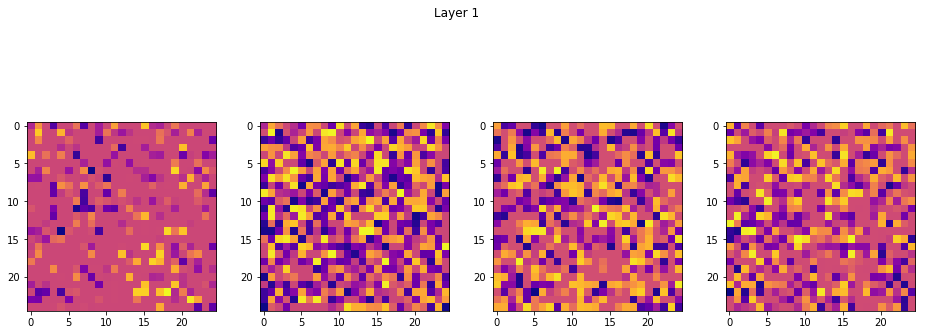

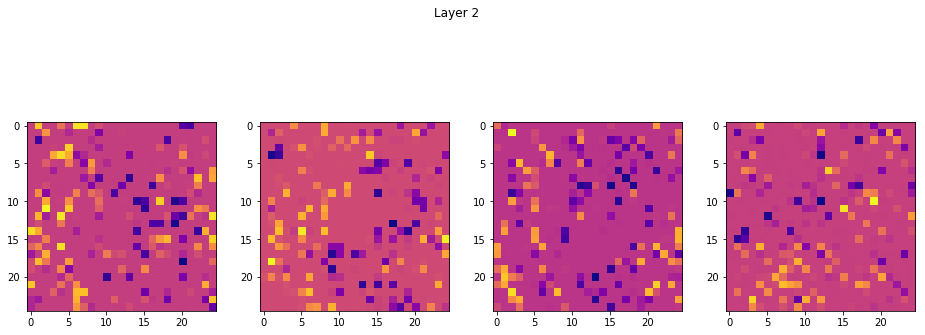

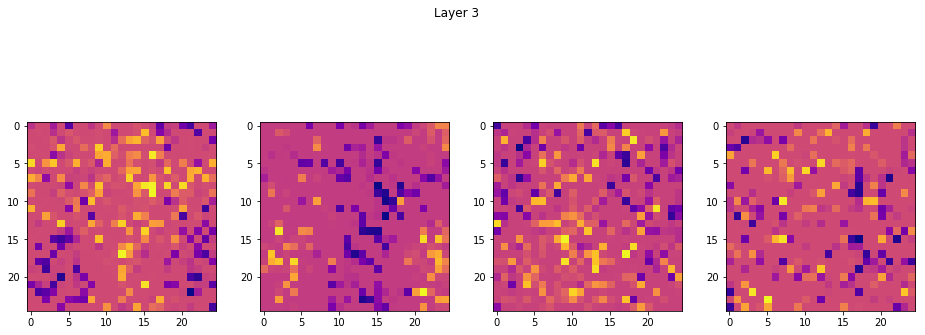

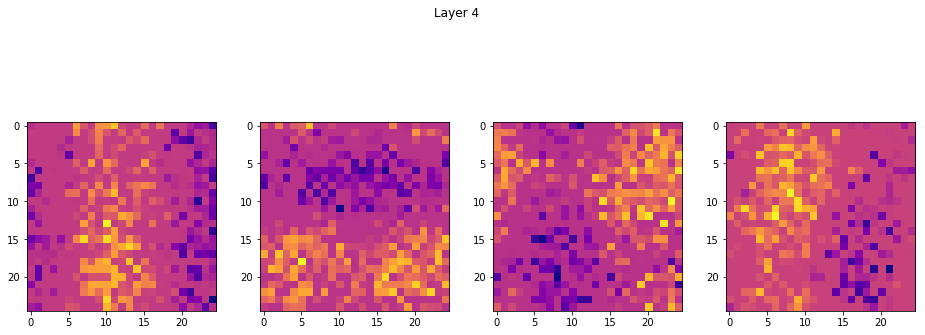

In [300]:
viz = ActivationVisualization(model=wide_4_model_dropout, lattice_size=25, verbose=False)

layers = [0, 3, 6, 12]

for layer_num, layer in enumerate(layers):
  plt.figure(figsize=(16, 16))
  plt.tight_layout()
  plt.suptitle(f"Layer {layer_num+1}")
  for i in range(4):
    plt.subplot(4, 4, i+1)
    viz.run_visualization(layer_number=layer, neuron=i, opt_steps=1000, target=1,
                        lr=0.01, weight_decay=1e-4, regularizer_weight=0.1)

  plt.show()

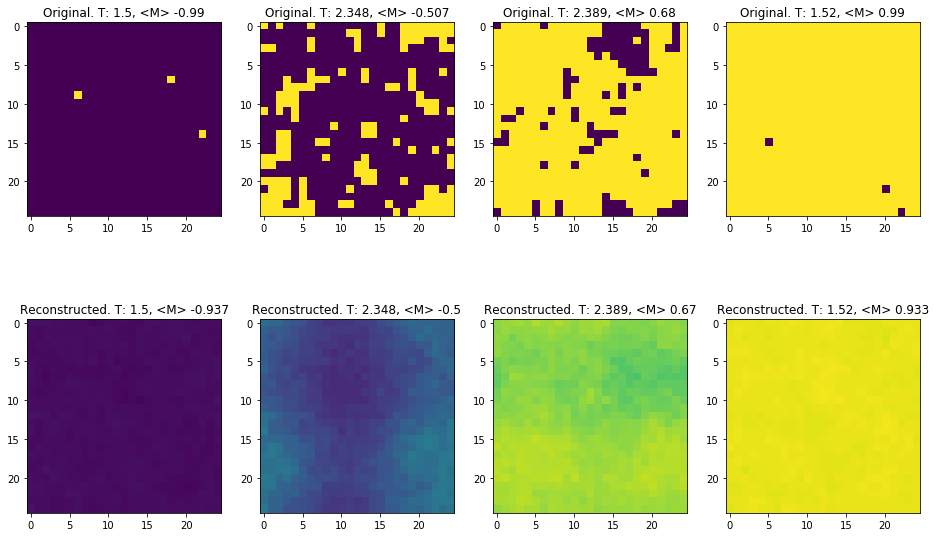

In [302]:
crit_index = np.argmin(np.abs(dataset.temperatures - CRITICAL_TEMP)) + 1000
plot_reconstructions(wide_4_model_dropout, [0, crit_index-20, crit_index + 220, 200])

### 4.2 Latent Dimensionality of 8

Increasing to al latent dimension of 8without regularization creates the same dynamic of macro-feature learning and poor phase-transition identification as seen with 16. We decided to explore the results obtained under the dropout regularization from the original model.

This produced our best result yet with a correlation coefficient of 0.98. Given the relative success of this model, we were interested in establishing whether - despite the absence of evidence of renormalization - the increased latent dimension would yield any quantifiable advantage over the single latent value model. This is explored in the next section.

In [0]:
class WideAutoencoder8(nn.Module):
    def __init__(self, lattice_size, model_tag, p_dropout=0.5):
        super().__init__()
        
        self.model_tag = model_tag
        
        self.encoder = nn.Sequential(
            nn.Linear(lattice_size**2, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 8),
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(32, 64),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Dropout(p_dropout),
            nn.Linear(256, lattice_size**2),
            nn.Tanh()
        )

    def forward(self, x):
        encoded_values = self.encoder(x)
        x = self.decoder(encoded_values)
        return x, encoded_values

In [326]:
dropout = 0.5

num_epochs = 100
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 0
schedule = []
checkpoints = []

WIDE_8_TAG_DROPOUT = "Z_8_dropout"
wide_8_model_dropout = WideAutoencoder8(
    lattice_size, WIDE_8_TAG_DROPOUT, dropout).cuda()

if cuda:
    wide_8_model_dropout = wide_8_model_dropout.cuda()

wide_8_model_dropout, loss = train_model(model=wide_8_model_dropout,
                                  dataset = dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)
encoded = encode_data(wide_8_model_dropout, dataset)

epoch [10/100], loss:0.9384
epoch [20/100], loss:0.7599
epoch [30/100], loss:0.7159
epoch [40/100], loss:0.7006
epoch [50/100], loss:0.6888
epoch [60/100], loss:0.6831
epoch [70/100], loss:0.6763
epoch [80/100], loss:0.6719
epoch [90/100], loss:0.6689
epoch [100/100], loss:0.6651
Final loss: loss:0.6651


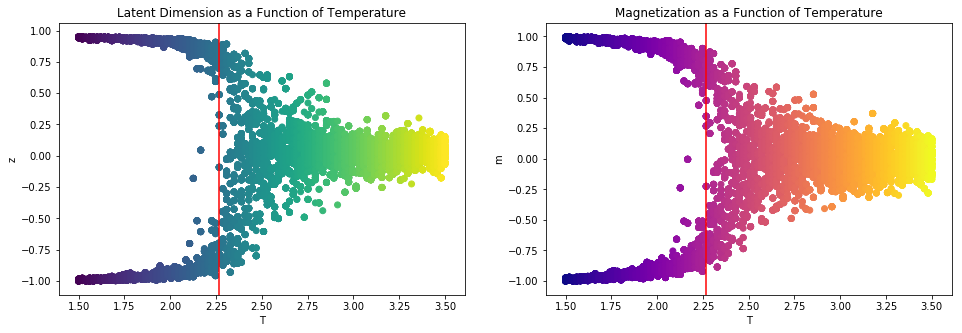

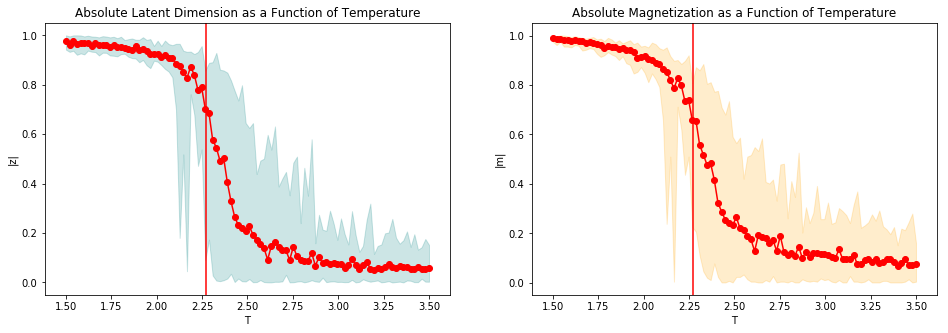

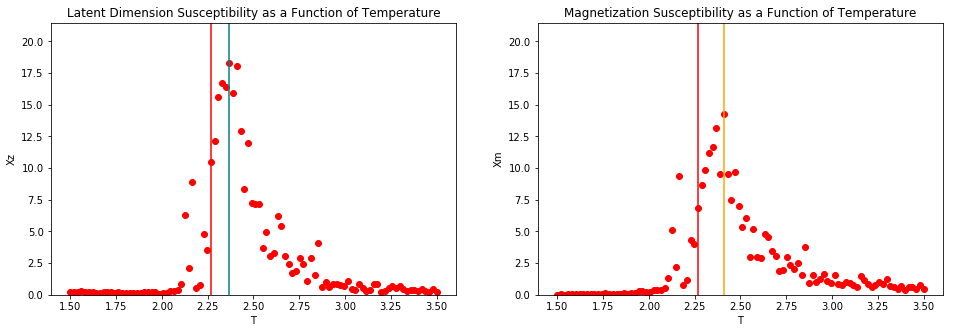

Max Susceptibility is at T = 2.369 Ground Truth:  2.269185
Absolute percent error:  4.399 %
Correlation coeff:  0.983


In [327]:
run_phase_analysis(WIDE_8_TAG_DROPOUT, lattice_size=25, N=200, scale=True)
run_critical_temp_analysis(WIDE_8_TAG_DROPOUT, lattice_size=25, N=200, scale=True)

## 5. Phase Transition Dynamics Under Wider Autoencoders

As briefly mentioned above, the single latent value model makes identification of a second-order phase transition virtually impossible. Here, I briefly establish the theory of phase transitions and then discuss why a wider dimension may be useful.

A first order phase transition represents a discontinuous change in the first derivative of free energy of a system with respect to some parameter. A second order phase transition represents a discontinuous change in the second derivative. At a very high level, these correspond to different dynamics in the system under consideration.

The magnetic susceptibility is the second derivative of the free energy with respect to the magnetic field. It is this susceptibility which undergoes a discontinuous change at the critical temperature. So we should, on paper, expect to see a second-order phase transition which will show up on the absolute latent susceptibility graph as a smooth but steep change with a switch in concavity in the middle. 

The original paper only shows a first-order change, a sudden jump from a high value to a low, which indicates a first-order change (a sudden change in the first derivative). It appears from the absolute graph above that the wider model may show a second-order phase transition. This is no unreasonable a priori given that the larger latent dimension may contain enough information to capture the intermediate dynamics which are lost in the single value model. However, it is also possible that this is a finite size effect and that a larger lattice would reveal this effect to be spurious.

#### Results

Below, we train the original model and the autoencoder with a latent dimension of 8 (the best performing model) on data corresponding to a 50 by 50 lattice. The resultant figures appear to confirm that the effect observed on a 25 by 25 lattice was spurious. The original model and the latent-8 model are similarly steep in transition and we suspect that under larger lattices, we would see the first-order phase transition which the original authors see when using larger lattices.

The move towards a first-order transition is confirmed by the much lower correlation score achieved by both models (around 0.5 and 0.4 for the original and latent-8 autoencoder respectively). As evident from the figures, the low correlation captures the loss of accuracy around the critical value where the emprical susceptibility smooothly transitions from near zero to a peak while the latent susceptibility jumps from zero to a peak.

At a minimum, this confirms the value of the metric. 

In [0]:
large_lattice_size=50
N = 200
file_name = f"ising_data_lattice_{large_lattice_size}_N_{N}"
large_dataset = IsingDataset(file_name)

In [331]:
# Learning params
num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
p_dropout = 0.5
schedule = []
checkpoints = []
L1_reg = 0
  
# Build model
ORIGINAL_LARGE_MODEL_TAG = "Z_DIM_1_LARGE"
original_large_model = OriginalAutoencoder(
    large_lattice_size, ORIGINAL_LARGE_MODEL_TAG, p_dropout=p_dropout).cuda()

if cuda:
    original_large_model = original_large_model.cuda()


# Train
original_large_model, loss = train_model(model=original_large_model,
                                  dataset = large_dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

epoch [20/200], loss:0.7755
epoch [40/200], loss:0.7017
epoch [60/200], loss:0.6798
epoch [80/200], loss:0.6758
epoch [100/200], loss:0.6751
epoch [120/200], loss:0.6743
epoch [140/200], loss:0.6740
epoch [160/200], loss:0.6737
epoch [180/200], loss:0.6735
epoch [200/200], loss:0.6732
Final loss: loss:0.6732


In [0]:
encoded = encode_data(original_large_model, large_dataset)

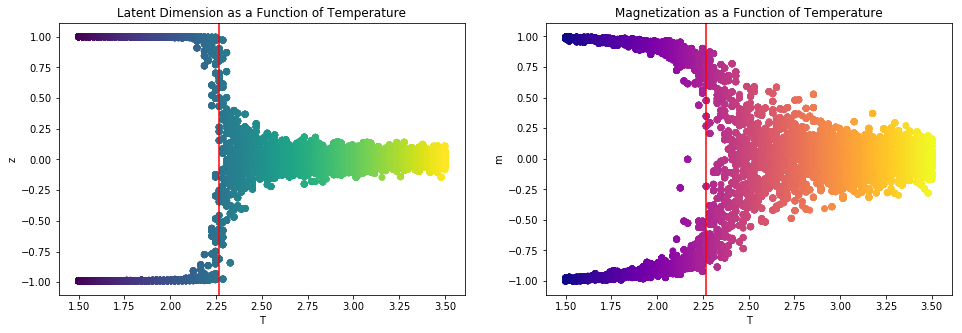

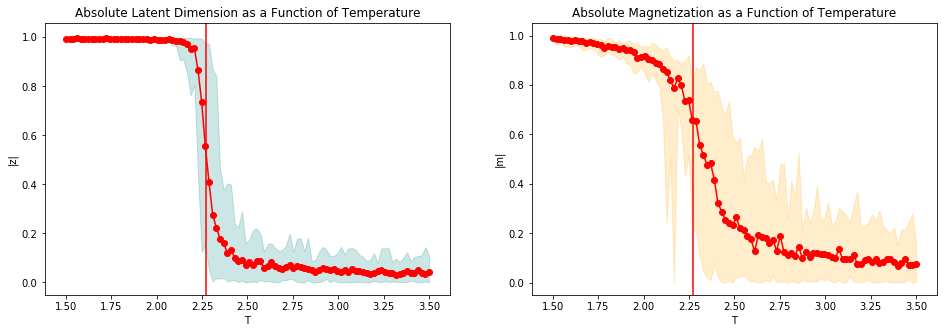

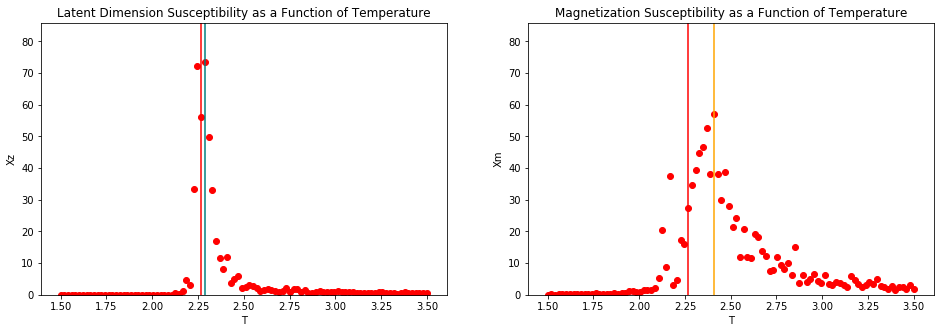

Max Susceptibility is at T = 2.288 Ground Truth:  2.269185
Absolute percent error:  0.829 %
Correlation coeff:  0.493


In [333]:
run_phase_analysis(ORIGINAL_LARGE_MODEL_TAG, lattice_size=50, N=200, scale=True)
run_critical_temp_analysis(ORIGINAL_LARGE_MODEL_TAG, lattice_size=50, N=200, scale=True)

#### Second order phase transition in 50 lattice with wide autoencoder

In [339]:
dropout = 0.5

num_epochs = 200
batch_size = 40000
learning_rate = 1e-3
weight_decay = 1e-4
L1_reg = 0
schedule = []
checkpoints = []

WIDE_8_TAG_LARGE = "Z_8_large"
wide_8_model_large = WideAutoencoder16(
    large_lattice_size, WIDE_8_TAG_LARGE, dropout).cuda()

if cuda:
    wide_8_model_large = wide_8_model_large.cuda()

wide_8_model_large, loss = train_model(model=wide_8_model_large,
                                  dataset = large_dataset,
                                  dataset_tag = file_name,
                                  loss_function = reconstruction_loss,
                                  num_epochs = num_epochs, batch_size = batch_size,
                                  weight_decay = weight_decay, learning_rate = learning_rate, 
                                  L1_reg = L1_reg, schedule = schedule,
                                  checkpoints = checkpoints, verbose = True)

encoded = encode_data(wide_8_model_large, large_dataset)

epoch [20/200], loss:0.7700
epoch [40/200], loss:0.7214
epoch [60/200], loss:0.7033
epoch [80/200], loss:0.6920
epoch [100/200], loss:0.6865
epoch [120/200], loss:0.6819
epoch [140/200], loss:0.6789
epoch [160/200], loss:0.6769
epoch [180/200], loss:0.6754
epoch [200/200], loss:0.6745
Final loss: loss:0.6745


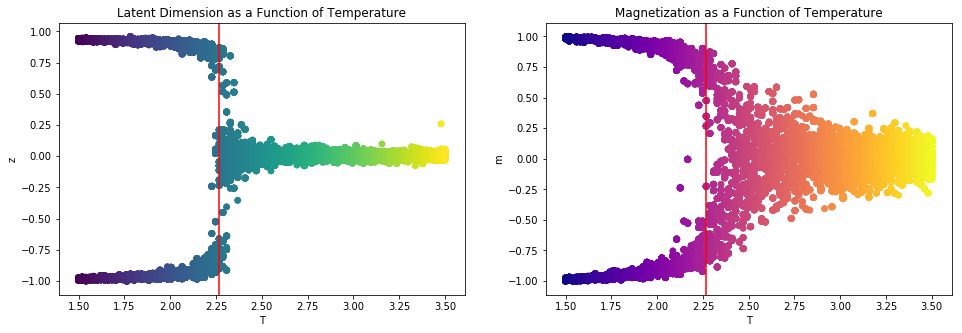

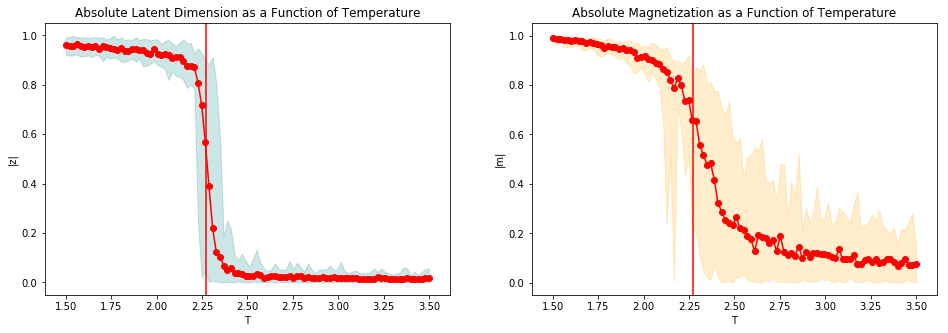

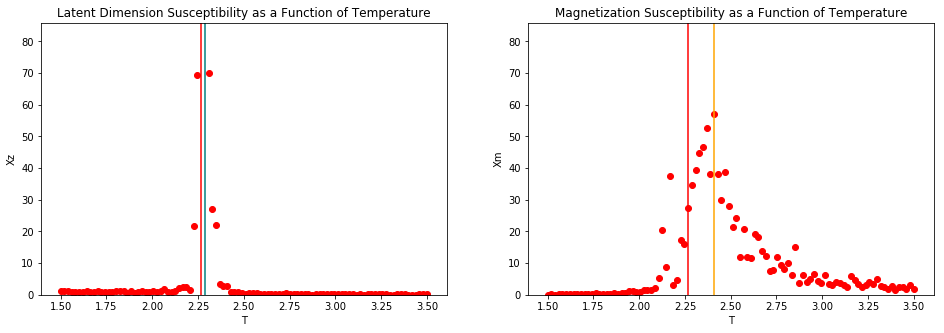

Max Susceptibility is at T = 2.288 Ground Truth:  2.269185
Absolute percent error:  0.829 %
Correlation coeff:  0.39


In [340]:
run_phase_analysis(WIDE_8_TAG_LARGE, lattice_size=50, N=200, scale=True)
run_critical_temp_analysis(WIDE_8_TAG_LARGE, lattice_size=50, N=200, scale=True)

## Appendix

## Possible Next Steps

Firstly, given more time and resources, we would run the analysis above on larger lattice sizes and with more samples per temperature and more temperatures. This would provide more certain metric values and potentially reveal divergent dynamics in different network structures.

Second, we should have maintained a test and train split in the data to provide clear and direct overfitting metrics. Without this, we were forced to infer overfitting from the (hypithesized) indirect impact on other metrics.

Third, we thought about using a Variational Autoencoder to more closely mirror the loss functions used to train Deep Belief Networks in Metha & Schwab (2014). Without further work, it is unclear if this would be advantageous or would result in renormalization. 

Another interesting idea, discussed with Professor Howe, would be to execute layer by layer training of the autoencoder: first training with a latent dimension larger than one to allow for more information to be represented and then introducing a new set of intermediate layers with a final latent dimension of 1. It is possible renormalization would emerge as a strategy under a scheme which balances allowing more latent information with more, eventual, compression.

Another next step would be to apply this model to other data with analogous, or more complex, phase transitions to confirm that the ability of the network to identify a phase transitions extends beyond the ising model.

Finally, given a working model model which displayed local clustering, it would become paramount to develop a metric to quantify this clustering. This is a non-trivial problem. We pre-emptively began development of such a metric but abandoned work when it became clear that the clustering in activation we observed was not resulting from renormalization. We discuss this metric below.

### Activation Locality/Clustering Metric

Under renormalization, we would expect to see clearly defined clusters of input values activating different higher-layer neurons. Where this clustering is in "location space".

In order to quantify this, we implemented the following: we first identify which sites in the input space activate a specific neuron by running the optimization described above and then filtering inputs sites with a value some number of standard deviations above the mean input value (where the number of standad deviations is a hyper-parameter). We then treat the locations of these filtered sites as observations in a K-means clustering algorithm. 

In order to determine the number of clusters we implemented an psuedo-automatic version of the elbow method. This identifies the point at which additional clusters yield decreasing marginal return to the intra-cluster variance of observations by looking at the second derivative of the intracluster variance against number of clusters. The automatic identification is prone to occasional error/degeneracy resulting in the need for manual confirmation.

Finally, given the 'optimal' number of clusters, we generate a metric value by penalizing intracluster variance and cluster count, normalized by the total number of input values being processed. This metric was designed to rewad few (ideally one) tigher (low variance) cluster independant of characteristic scale.

Below, we confirm that this metric is lower (better) for an input value example which shows one clear (positive) cluster vs a noisy/unclustered input.



In [0]:
def cluster(array,threshold):
    # Apply Threshold
    X = apply_threshold(array,threshold)
    
    # K-means
    K = range(1,8)
    KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 20
    centroids = [cent for (cent,var) in KM]   # cluster centroids
    vars = np.array([var for (cent,var) in KM]) # in-cluster variance
    
    # Auto-detect Three Elbows
    second_der = np.ediff1d(np.ediff1d(vars))
    abs_second_der = np.abs(second_der)
    elbows = np.sort(np.add(np.argsort(abs_second_der)[::-1][:3],2))

    # Plot Elbow Curve
    
    plt.figure(figsize=(20,5))
    
    
    plt.subplot(151)
    plt.plot(K, vars, 'bo-')
    plt.plot(range(2,len(K)),second_der)
    for elbow in elbows:
        plt.plot(K[elbow-1], vars[elbow-1], marker='o', markersize=12, 
              markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for K-Means clustering')
    
    #Display Cluster Visualizations
    for i in range(len(elbows)):
        plt.subplot(152+i)
        visualize_clusters(X, array, elbows[i])
        
    plt.subplot(155)
    plt.imshow(raw, cmap="plasma")
        
    plt.show()

def apply_threshold(array,threshold):
    
    # Determine Threshold
    mask = np.mean(array)+threshold*np.std(array)
    
    # Apply Threshold
    ind_x, ind_y = np.where(array>mask)
    
    # Classified Positions
    indices = combinations(range(len(ind_x)),2)
    
    positions = set()
    for pos_ind1,pos_ind2 in indices:
        positions.add((ind_x[pos_ind1],ind_y[pos_ind1]))
        
    return np.array(list(positions)).astype(float)
    
def visualize_clusters(X, array, count):
    # Fit K-Means
    km = KMeans(count, init="k-means++") # initialize
    km.fit(X)
    c = km.predict(X) # classify into three clusters
        
    # Assign positions and colors
    raw = np.full(array.shape, -1)
    for pos, clus in zip(X, c):
        raw[int(pos[1]), int(pos[0])] = clus

    #Plot
    plt.title(f"{count} Clusters")
    plt.imshow(raw, vmin=-1, vmax=10, cmap="gist_ncar")
    
def cluster_loss(X, count):
    _,var = kmeans(X, count)
    
    return var*count/len(X)

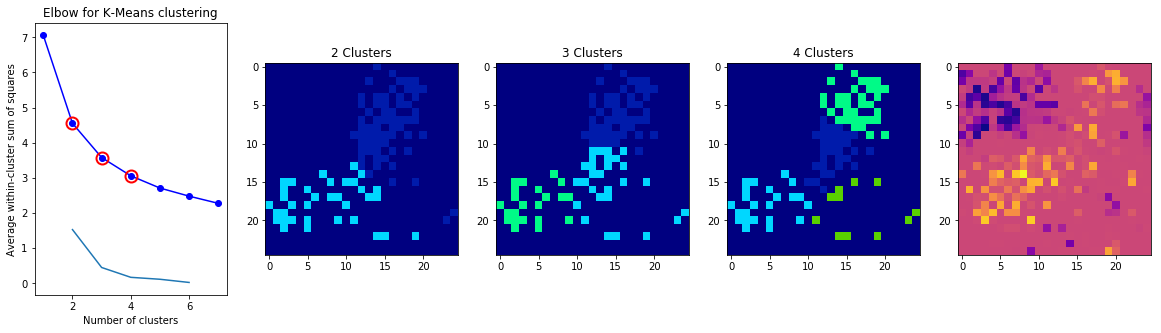

Cluster loss 0.07127458167438964


In [310]:
raw = no_reg_cluster_data[-2].reshape((lattice_size, lattice_size))
threshold = 0.25
cluster(raw, threshold=threshold)

plt.show()

print("Cluster loss", cluster_loss(apply_threshold(raw, threshold), 1))

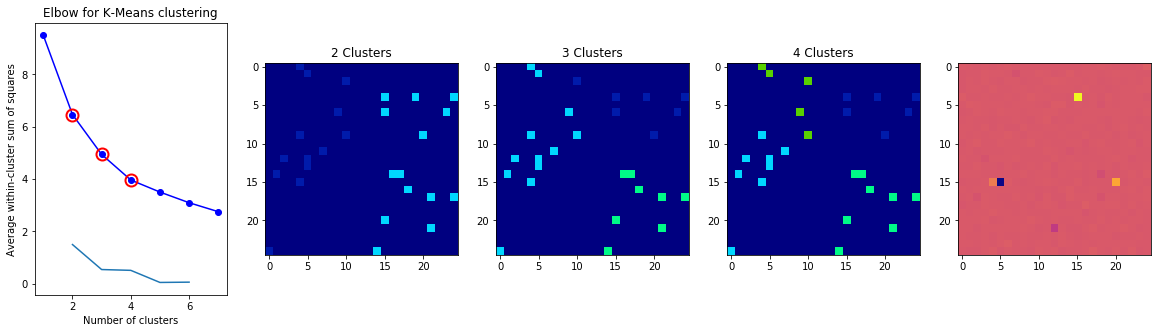

Cluster loss 0.5875576995657562


In [313]:
raw = wide_16_l1_cluster_data[-2].reshape((lattice_size, lattice_size))
threshold = 0.25
cluster(raw, threshold=threshold)

plt.show()

print("Cluster loss", cluster_loss(apply_threshold(raw, threshold), 4))

## References

Alexandrou, C., Athenodorou, A., Chrysostomou, C., & Paul, S. (2019). Unsupervised identification of the phase transition on the 2D-Ising model. Retrieved from http://arxiv.org/abs/1903.03506

Kyalondawa Kyimba, E.-A. (2006). Comparison of Monte Carlo Metropolis, Swendsen-Wang, and Wolff Algorithms in the Critical Region for the 2-Dimensional Ising Model. (Under the direction of Dean J. Lee.). Retrieved from https://repository.lib.ncsu.edu/bitstream/handle/1840.16/110/etd.pdf?sequence=1&isAllowed=y

Mehta, P., & Schwab, D. J. (2014). An exact mapping between the Variational Renormalization Group and Deep Learning. Retrieved from http://arxiv.org/abs/1410.3831

Stanley, H. E. (1999). Scaling, universality, and renormalization: Three pillars of modern critical phenomena. In Reviews of Modern Physics (Vol. 71). Retrieved from http://cps-www.bu.edu/hes/articles/s99a.pdf